
| 분류 | 변수명 (Features) | 비고 |
| :--- | :--- | :--- |
| **기본 지표** | `PRICE_MEDIAN`, `COUNTS` | 실거래가 중앙값, 거래량 |
| **거시 경제** | `BASE_RATE`, `REAL_RATE`, `HOUSE_RATE`, `CPI`, `CPI_YOY` | 기준/실질/주담대 금리, 소비자물가지수 등 |
| **시장 압력** | `JEONSE_PRICE`, `JEONSE_RATIO`, `JEONSE_RATIO_CHANGE` | 전세가 지수, 전세가율 및 변화량 |
| **시계열/기술** | `LAG_1, 3, 6`, `MA_3, 6`, `VOLATILITY_3M` | 과거 시차 변수(Lag), 이동평균(MA), 변동성 |
| **계절성** | `MONTH_SIN`, `MONTH_COS`, `QUARTER` | 월(Sin/Cos 변환), 분기별 주기성 데이터 |

#### 모델링
- 회귀 모델: XGBRegressor (Main Model)
    - 목표: 3개월 후 매매가 변화율(%) 수치 예측
        - 성능 지표:
            - $R^2$ (결정계수): 0.9343 (매우 높음)
            - MAE (평균 절대 오차): 0.0408
        - 결론: 시장의 가격 변동 추세를 93% 이상의 정확도로 설명 가능. 수치 기반 투자 판단에 매우 적합함.
- 분류 모델: RandomForestClassifier
    - 목표: 상승(>2%), 보합, 하락(<-2%) 3개 클래스 분류
    - 성능 지표: F1-Score: 0.524 / Accuracy: 0.536
    - 특이사항: 상승/하락의 방향성은 준수하게 포착하나, '보합' 구간의 노이즈가 존재함. (XGBoost 회귀 결과와 병행 활용 권장)

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler

plt.rcParams['font.family'] = 'Malgun Gothic' 

df = pd.read_csv('/home/hyuksu/projects/ml/project/데이터/FIN_DATA_JEONSE2.csv')
print(df.info())
print(df.columns.tolist())
print(df.head())
# 날짜 datetime 타입으로 변환
df['DATE_YM'] = pd.to_datetime(df['DATE_YM'], format='%Y%m')
print(df.shape)
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4572 entries, 0 to 4571
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   DATE_YM       4572 non-null   int64  
 1   STATES        4572 non-null   object 
 2   SIZE          4572 non-null   object 
 3   PRICE_MEDIAN  4572 non-null   float64
 4   COUNTS        4572 non-null   int64  
 5   CPI           4572 non-null   float64
 6   BASE_RATE     4572 non-null   float64
 7   CPI_YOY       4572 non-null   float64
 8   REAL_RATE     4572 non-null   float64
 9   HOUSE_RATE    4572 non-null   float64
 10  VARIABLED     4572 non-null   float64
 11  JEONSE_PRICE  4572 non-null   float64
 12  JEONSE_RATIO  4572 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 464.5+ KB
None
['DATE_YM', 'STATES', 'SIZE', 'PRICE_MEDIAN', 'COUNTS', 'CPI', 'BASE_RATE', 'CPI_YOY', 'REAL_RATE', 'HOUSE_RATE', 'VARIABLED', 'JEONSE_PRICE', 'JEONSE_RATIO']
   DATE_YM STATES SI

DATE_YM         0
STATES          0
SIZE            0
PRICE_MEDIAN    0
COUNTS          0
CPI             0
BASE_RATE       0
CPI_YOY         0
REAL_RATE       0
HOUSE_RATE      0
VARIABLED       0
JEONSE_PRICE    0
JEONSE_RATIO    0
dtype: int64

In [63]:
#파생변수 만들기
#datetime(DATE_YM)생성\
df['YEAR'] = df['DATE_YM'].dt.year
df['MONTH'] = df['DATE_YM'].dt.month
df['QUARTER'] = df['DATE_YM'].dt.quarter #분기


In [64]:
#시계열 데이터 모델링 할 때 사인, 코사인(계절성)으로 변환하는게 모델 성능에 좋다고 함 (https://time-series.tistory.com/3, https://medium.com/@daisyonapril/%EC%8B%9C%EA%B3%84%EC%97%B4-%EB%B6%84%EC%84%9D-%EC%89%BD%EA%B2%8C-%EC%9D%B4%ED%95%B4%ED%95%98%EA%B8%B0-585c92bc1852)
df['MONTH_SIN'] = np.sin(2 * np.pi * df['MONTH']/12) #이걸하면 12월이랑 1월 가깝다는거안다고함
df['MONTH_COS'] = np.cos(2 * np.pi * df['MONTH']/12)

df = df.sort_values(['STATES', 'SIZE','DATE_YM']).reset_index(drop=True) #변수 만들기전에 정렬

In [65]:
#시차변수(log)생성(https://eiec.kdi.re.kr/policy/domesticView.do?ac=0000190411, 금융 데이터 머신러닝에서 쓴다고 함)
#shift:shift메서드는 시계열 데이터의 데이터나 인덱스를 원하는 기간만큼 쉬프트 하는 메서드 입니다. (https://wikidocs.net/158146)
df['LAG_1'] = df.groupby(['STATES', 'SIZE'])['PRICE_MEDIAN'].shift(1)#1개월
df['LAG_3'] = df.groupby(['STATES', 'SIZE'])['PRICE_MEDIAN'].shift(3)#3개월
df['LAG_6'] = df.groupby(['STATES', 'SIZE'])['PRICE_MEDIAN'].shift(6)#6개월
# LAG_1(1개월전가겨ㅑㄱ) LAG_3(3갤전가격) LAG_6(6갤전가격)

In [66]:
#이동평균 생성, 부동산에서 쓰는지 모르겠는데 주식 머신러닝에서 쓰는 거 가져옴ㅎ(https://zephyrus1111.tistory.com/207)
#rolling 쓰는 방법 https://scribblinganything.tistory.com/386
grouped = df.groupby(['STATES', 'SIZE'])['PRICE_MEDIAN']

df['MA_3'] = grouped.rolling(3, min_periods=1).mean().reset_index(level=[0,1], drop=True)
df['MA_6'] = grouped.rolling(6, min_periods=1).mean().reset_index(level=[0,1], drop=True)
print(df['MA_6'])
#MA_3(3갤이동평균가격) MA_6(6갤이동평균가격)

0       128750.000000
1       130875.000000
2       130916.666667
3       133000.000000
4       133400.000000
            ...      
4567    123458.333333
4568    124083.333333
4569    123916.666667
4570    126000.000000
4571    128666.666667
Name: MA_6, Length: 4572, dtype: float64


In [67]:
#3갤변동성변수생성(캔들차트 그거...)
df['VOLATILITY_3M'] = grouped.rolling(3, min_periods=1).std().reset_index(level=[0,1], drop=True)
#VOLATILITY_3M(3갤변동성)


In [68]:
# 전세가율 변화율
# 같은 지역 같은 평형에서, 이번달 기준, 전세가율이 지난달보다 몇퍼 올랐거나 내렸? 지난달 전세가율 60% → 이번 달 63% → (63-60)/60=0.05 → *100 -> 5퍼상승..?
df['JEONSE_RATIO_LAST_MONTH'] = df.groupby(['STATES', 'SIZE'])['JEONSE_RATIO'].shift(1)
df['JEONSE_RATIO_CHANGE'] = (df['JEONSE_RATIO'] - df['JEONSE_RATIO_LAST_MONTH']) / df['JEONSE_RATIO_LAST_MONTH'] * 100
#
df = df.drop(columns=['JEONSE_RATIO_LAST_MONTH'])
#print(df['JEONSE_RATIO_CHANGE'])
df = df.fillna(0)
print(df['JEONSE_RATIO_CHANGE'].info)

<bound method Series.info of 0       0.000000
1      -0.340716
2       0.000000
3       0.170940
4      -1.023891
          ...   
4567    1.401051
4568    0.000000
4569   -1.208981
4570   -0.524476
4571   -1.405975
Name: JEONSE_RATIO_CHANGE, Length: 4572, dtype: float64>


In [69]:
df.info()
##DATE_YM:년월, STATES:자치구, SIZE:평형별크기(대형,중형,소형), PRICE_MEDIAN:실거래가중앙값. COUNTS:거래건수(실거래), CPI:소비자물가지수, BASE_RATE:기준금리, CPI_YOY:물가상승률(전년동월), REAL_RATE:실질금리, HOUSE_RATE:주담대금리, VARIABLED:3개월후실거래가변화율(y데이터), JEONSE_PRICE:전세가격지수, JEONSE_RATIO:전세가율(매매가대비전세가),
#새로생긴변수명및간단설명: 'YEAR'연도, 'MONTH'월, 'QUARTER'분기, 'MONTH_SIN'사인, 'MONTH_COS'코사인, 'LAG_1'1개월전가격, 'LAG_3'3개월전가격, 'LAG_6'6개월전가격, 'MA_3'3개월평균가격, 'MA_6'6개월평균가격, 'VOLATILITY_3M'3개월동안가격변동성, 'JEONSE_RATIO_CHANGE'전세가율변화율
#새로생긴변수: 'YEAR', 'MONTH', 'QUARTER', 'MONTH_SIN', 'MONTH_COS', 'LAG_1', 'LAG_3', 'LAG_6', 'MA_3', 'MA_6', 'VOLATILITY_3M', 'MOMENTUM_3M', 'JEONSE_RATIO_CHANGE'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4572 entries, 0 to 4571
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE_YM              4572 non-null   datetime64[ns]
 1   STATES               4572 non-null   object        
 2   SIZE                 4572 non-null   object        
 3   PRICE_MEDIAN         4572 non-null   float64       
 4   COUNTS               4572 non-null   int64         
 5   CPI                  4572 non-null   float64       
 6   BASE_RATE            4572 non-null   float64       
 7   CPI_YOY              4572 non-null   float64       
 8   REAL_RATE            4572 non-null   float64       
 9   HOUSE_RATE           4572 non-null   float64       
 10  VARIABLED            4572 non-null   float64       
 11  JEONSE_PRICE         4572 non-null   float64       
 12  JEONSE_RATIO         4572 non-null   float64       
 13  YEAR                 4572 non-nul

In [70]:
#데이터 분할
#VARIABLED 결측치 아닌 행만 선택 ~isnull()
df_clean = df[~df['VARIABLED'].isnull()].copy()
df_clean.shape
#나누기 전에 정렬해야함 근데 시계열이라서 DATE_YM 시간순으로 순서 개중요
df_clean = df_clean.sort_values('DATE_YM').reset_index(drop=True)


In [71]:
#8:2로, 행 개수에서 80%
n_total = len(df_clean)
n_total
n_train = int(n_total * 0.8)
n_train

train = df_clean.iloc[:n_train]
test = df_clean.iloc[n_train:]
print(len(train),train['DATE_YM'].min(),train['DATE_YM'].max())
print(len(test),test['DATE_YM'].min(),test['DATE_YM'].max())

3657 2015-04-01 00:00:00 2023-09-01 00:00:00
915 2023-09-01 00:00:00 2025-10-01 00:00:00


In [72]:
# 하락 보합 상승으로 분류해야함
print(df['VARIABLED'].head(), df['VARIABLED'].describe()) #0.050981

def label_class(variabled):
    if variabled > 0.01:
        return 1#상승
    elif variabled < -0.01:
        return -1 #하락
    else:
        return 0 #보합
y_train_clf = train['VARIABLED'].apply(label_class)
y_test_clf = test['VARIABLED'].apply(label_class)

print((y_train_clf == -1).sum())
print((y_train_clf == 0).sum())
print((y_train_clf == 1).sum())
print(y_train_clf.size)

0   -0.030132
1    0.064000
2    0.007692
3    0.081553
4    0.015038
Name: VARIABLED, dtype: float64 count    4572.000000
mean        0.050981
std         0.295499
min        -0.830233
25%        -0.052606
50%         0.024938
75%         0.110181
max         4.178082
Name: VARIABLED, dtype: float64
1288
275
2094
3657


In [73]:
#시계열은train_test_split쓰면데이터누수남 그래서 사용할 변수들 하나하나 선택하고 그룹으로 묶을 예정. ssTATE랑 SIZE는 제외. 파생변수만들면서 계산해놨음(아마도..?)
study_cols = [
    'YEAR', 'MONTH', 'QUARTER',
    'PRICE_MEDIAN', 'COUNTS',
    'CPI', 'CPI_YOY',
    'BASE_RATE', 'REAL_RATE', 'HOUSE_RATE',
    'JEONSE_PRICE', 'JEONSE_RATIO', 'JEONSE_RATIO_CHANGE',
    'MONTH_SIN', 'MONTH_COS',
    'LAG_1', 'LAG_3', 'LAG_6', 'MA_3', 'MA_6',
    'VOLATILITY_3M'
    ]

X_train = train[study_cols]
y_train_reg = train['VARIABLED']  #회귀용y

X_test = test[study_cols]
y_test_reg = test['VARIABLED']

print(f"\n피처 개수: {len(study_cols)}")
print("사용 피처:", study_cols)



피처 개수: 21
사용 피처: ['YEAR', 'MONTH', 'QUARTER', 'PRICE_MEDIAN', 'COUNTS', 'CPI', 'CPI_YOY', 'BASE_RATE', 'REAL_RATE', 'HOUSE_RATE', 'JEONSE_PRICE', 'JEONSE_RATIO', 'JEONSE_RATIO_CHANGE', 'MONTH_SIN', 'MONTH_COS', 'LAG_1', 'LAG_3', 'LAG_6', 'MA_3', 'MA_6', 'VOLATILITY_3M']


In [74]:
# 스케일러는 Train 데이터만 써야함. 이 데이터를 기준으로 다른 데이터들한테 학습시켜줘야된다고함. https://wikidocs.net/145281
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
#스케일링된 데이터 X_train_scaled X_test_scaled

In [75]:
# 회귀(XGBoost)
xgb_reg = XGBRegressor(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_reg.fit(X_train_scaled, y_train_reg)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [76]:
y_pred_reg = xgb_reg.predict(X_test_scaled)

mae = mean_absolute_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
r2 = r2_score(y_test_reg, y_pred_reg)

print('--- XGBRegressor (회귀 모델) 결과 ---')
print(f'R² (결정계수): {r2:.4f}')
print(f'MAE (평균 절대 오차): {mae:.4f}')
print(f'RMSE (평균 제곱근 오차): {rmse:.4f}')

--- XGBRegressor (회귀 모델) 결과 ---
R² (결정계수): 0.9346
MAE (평균 절대 오차): 0.0394
RMSE (평균 제곱근 오차): 0.0624


In [77]:
# 분류RandomForest
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=6,
    min_samples_split=20,
    min_samples_leaf=10,
    class_weight='balanced_subsample',
    random_state=2424
)
rf_clf.fit(X_train, y_train_clf)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=6,
                       min_samples_leaf=10, min_samples_split=20,
                       random_state=2424)

In [78]:
from sklearn.metrics import accuracy_score
y_pred_clf=rf_clf.predict(X_test)
acc = accuracy_score(y_test_clf, y_pred_clf)

f1 = f1_score(y_test_clf, y_pred_clf, average='weighted')
print(f'정확도: {acc:.3f}')
print(f'F1 점수: {f1:.3f}')

report = classification_report(
    y_test_clf, y_pred_clf,
    target_names=['하락', '보합', '상승'],
    zero_division=0
)
print(report)

정확도: 0.589
F1 점수: 0.584
              precision    recall  f1-score   support

          하락       0.65      0.51      0.57       396
          보합       0.11      0.11      0.11        75
          상승       0.62      0.74      0.68       444

    accuracy                           0.59       915
   macro avg       0.46      0.45      0.45       915
weighted avg       0.59      0.59      0.58       915



In [79]:
from matplotlib import rc
rc('font',family='NanumGothic')

/tmp/ipykernel_23583/4175714636.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='XGBoost (Regression)', y='Feature', data=df_xgb, ax=axes[0], palette='viridis')
/tmp/ipykernel_23583/4175714636.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='RandomForest (Classification)', y='Feature', data=df_rf, ax=axes[1], palette='magma')


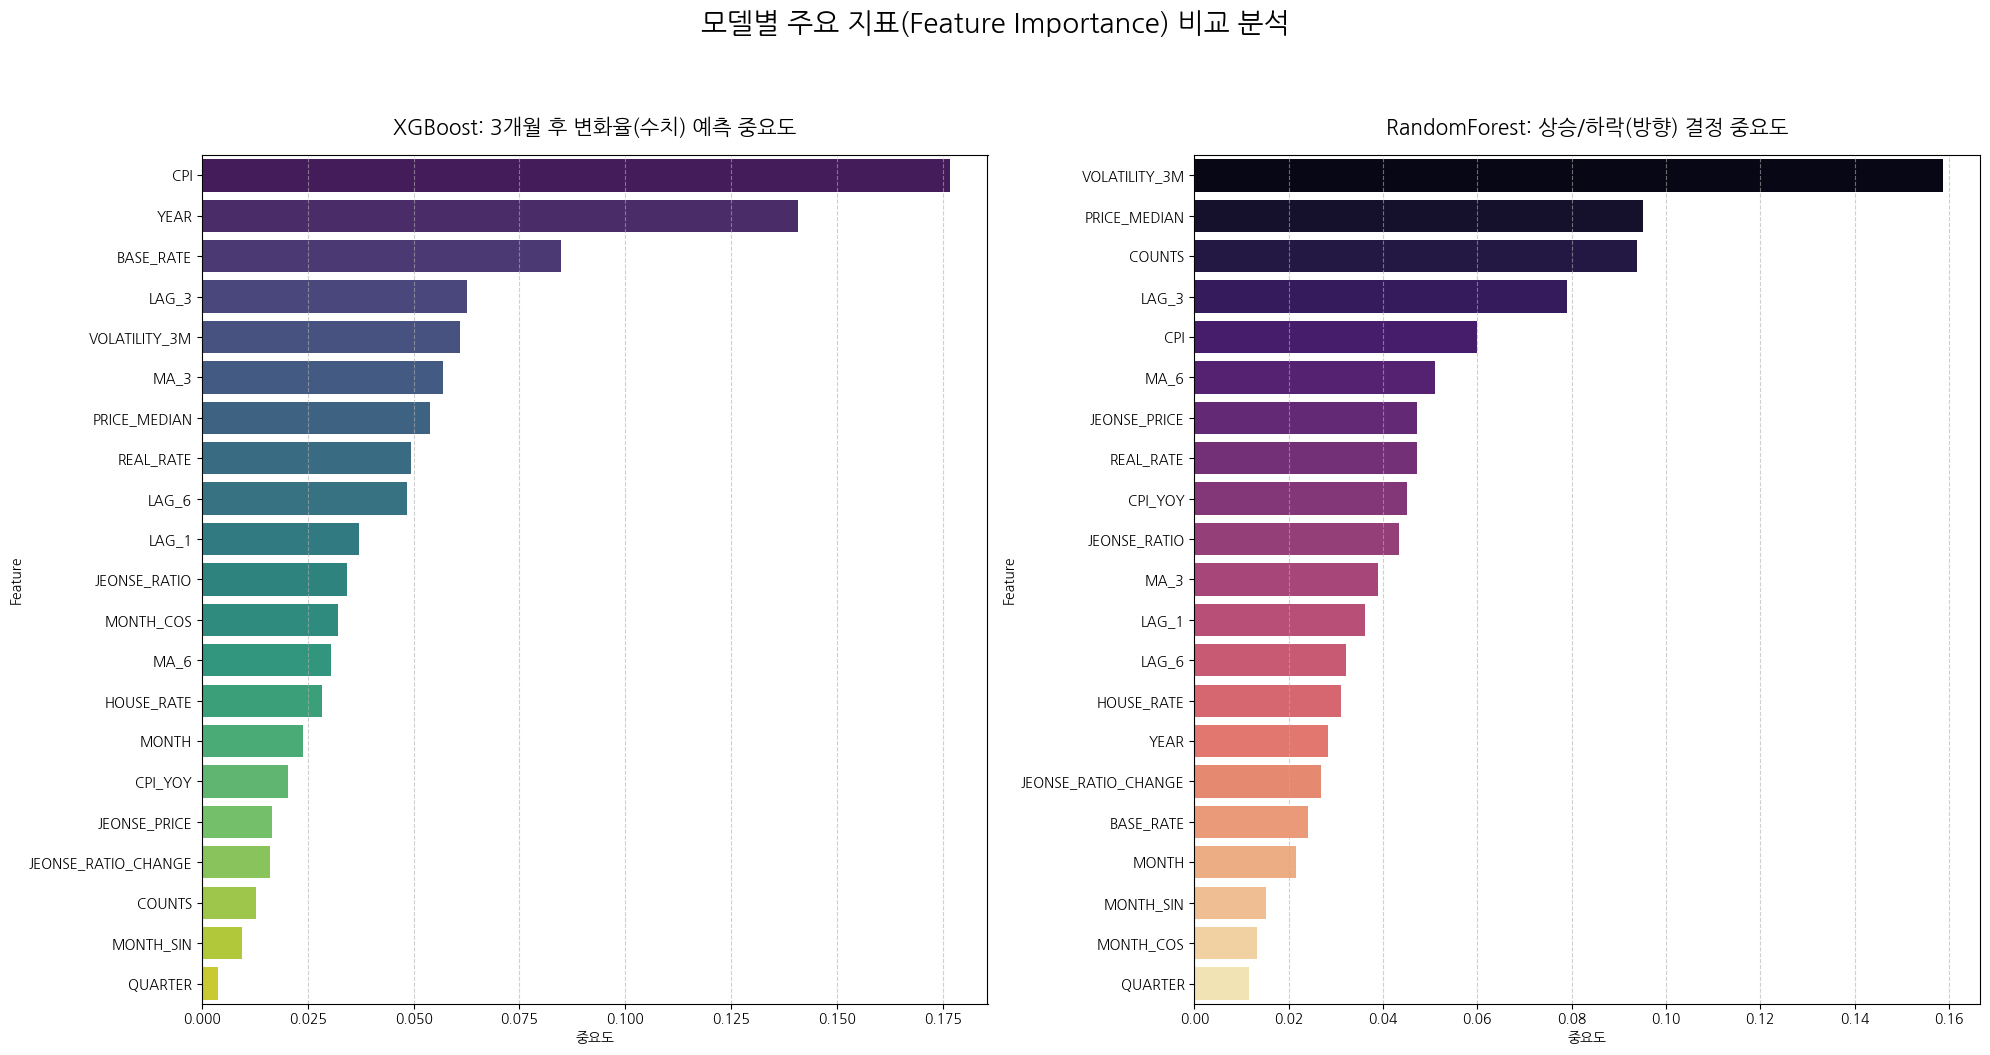

In [80]:
xgb_importances = xgb_reg.feature_importances_
rf_importances = rf_clf.feature_importances_

df_importance = pd.DataFrame({
    'Feature': study_cols,
    'XGBoost (Regression)': xgb_importances,
    'RandomForest (Classification)': rf_importances
})

# 2. 시각화 레이아웃 설정 (1행 2열)
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
plt.subplots_adjust(wspace=0.3) # 차트 간 간격 조절

# --- 왼쪽 차트: XGBoost (회귀) ---
df_xgb = df_importance.sort_values(by='XGBoost (Regression)', ascending=False)
sns.barplot(x='XGBoost (Regression)', y='Feature', data=df_xgb, ax=axes[0], palette='viridis')
axes[0].set_title('XGBoost: 3개월 후 변화율(수치) 예측 중요도', fontsize=15, pad=15)
axes[0].set_xlabel('중요도')
axes[0].grid(axis='x', linestyle='--', alpha=0.6)

# --- 오른쪽 차트: RandomForest (분류) ---
df_rf = df_importance.sort_values(by='RandomForest (Classification)', ascending=False)
sns.barplot(x='RandomForest (Classification)', y='Feature', data=df_rf, ax=axes[1], palette='magma')
axes[1].set_title('RandomForest: 상승/하락(방향) 결정 중요도', fontsize=15, pad=15)
axes[1].set_xlabel('중요도')
axes[1].grid(axis='x', linestyle='--', alpha=0.6)

plt.suptitle('모델별 주요 지표(Feature Importance) 비교 분석', fontsize=20, y=1.05)
plt.tight_layout()
plt.show()

/tmp/ipykernel_23583/2417116977.py:21: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  plt.tight_layout()
/home/hyuksu/projects/ml/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


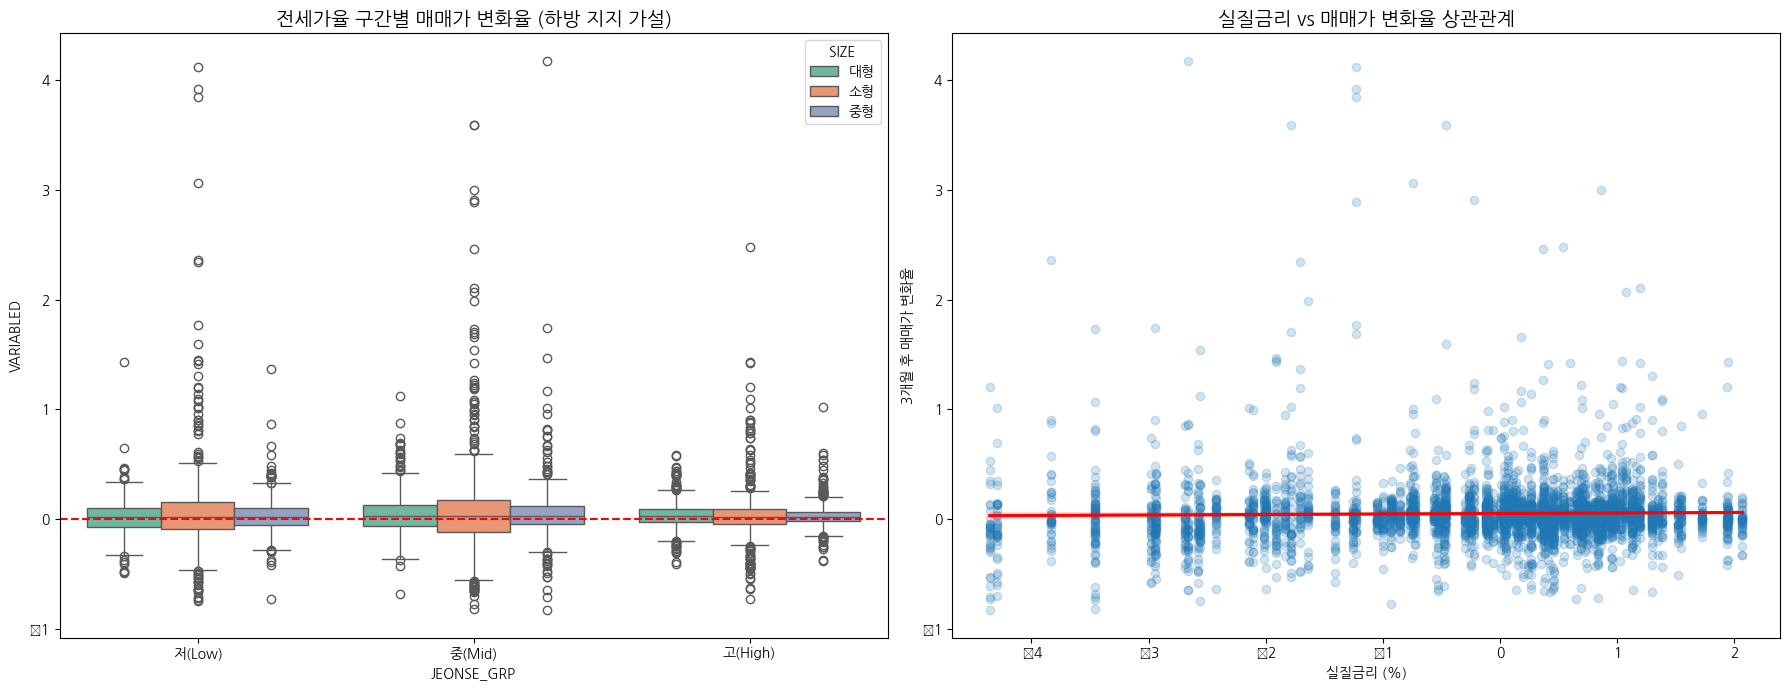

/home/hyuksu/projects/ml/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


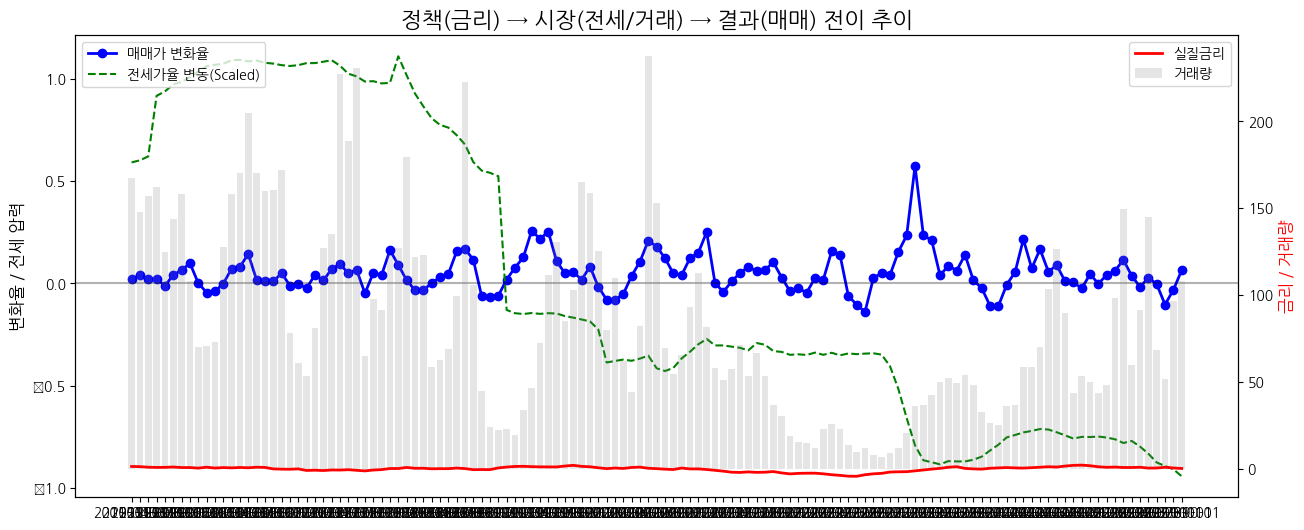

/home/hyuksu/projects/ml/.venv/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()
/home/hyuksu/projects/ml/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


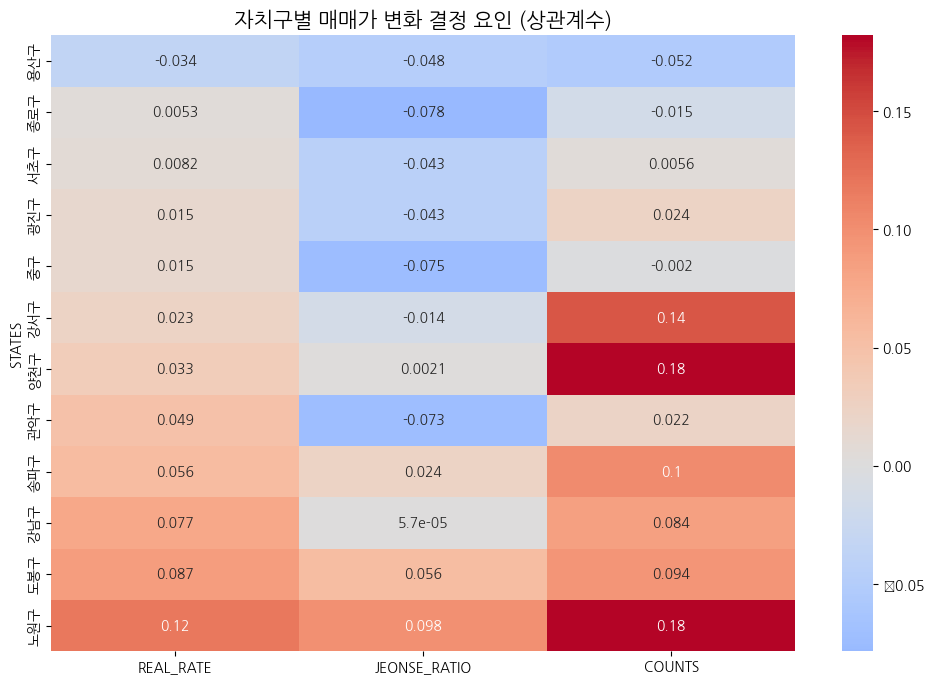

In [81]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 전세가율 구간 나누기 (저/중/고)
df['JEONSE_GRP'] = pd.qcut(df['JEONSE_RATIO'], 3, labels=['저(Low)', '중(Mid)', '고(High)'])

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# [가설 2 & 5] 전세가율 구간별 매매가 변화율과 거래량의 관계
sns.boxplot(data=df, x='JEONSE_GRP', y='VARIABLED', hue='SIZE', ax=axes[0], palette='Set2')
axes[0].set_title('전세가율 구간별 매매가 변화율 (하방 지지 가설)', fontsize=14)
axes[0].axhline(0, color='red', linestyle='--')

# [가설 1] 실질금리 vs 매매가 변화율 (금리 인상 영향력)
sns.regplot(data=df, x='REAL_RATE', y='VARIABLED', scatter_kws={'alpha':0.2}, line_kws={'color':'red'}, ax=axes[1])
axes[1].set_title('실질금리 vs 매매가 변화율 상관관계', fontsize=14)
axes[1].set_xlabel('실질금리 (%)')
axes[1].set_ylabel('3개월 후 매매가 변화율')

plt.tight_layout()
plt.show()

# 월별 전체 평균 데이터 생성
monthly_df = df.groupby('DATE_YM')[['VARIABLED', 'REAL_RATE', 'COUNTS', 'JEONSE_RATIO']].mean().reset_index()
monthly_df['DATE_YM'] = monthly_df['DATE_YM'].astype(str)

fig, ax1 = plt.subplots(figsize=(15, 6))

# 왼쪽 축: 매매가 변화율 & 전세가율
ax1.plot(monthly_df['DATE_YM'], monthly_df['VARIABLED'], color='blue', marker='o', label='매매가 변화율', linewidth=2)
ax1.plot(monthly_df['DATE_YM'], (monthly_df['JEONSE_RATIO']-monthly_df['JEONSE_RATIO'].mean())/10, 
         color='green', linestyle='--', label='전세가율 변동(Scaled)')
ax1.axhline(0, color='black', alpha=0.3)
ax1.set_ylabel('변화율 / 전세 압력', fontsize=12)

# 오른쪽 축: 실질금리 & 거래량
ax2 = ax1.twinx()
ax2.bar(monthly_df['DATE_YM'], monthly_df['COUNTS'], color='gray', alpha=0.2, label='거래량')
ax2.plot(monthly_df['DATE_YM'], monthly_df['REAL_RATE'], color='red', label='실질금리', linewidth=2)
ax2.set_ylabel('금리 / 거래량', color='red', fontsize=12)

plt.title('정책(금리) → 시장(전세/거래) → 결과(매매) 전이 추이', fontsize=16)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
#ax1.xaxis.set_major_locator(ticker.MaxNLocator(10))
plt.show()

# 자치구별 주요 지표 상관계수 요약
pivot_corr = df.groupby('STATES')[['VARIABLED', 'REAL_RATE', 'JEONSE_RATIO', 'COUNTS']].corr()['VARIABLED'].unstack()
pivot_corr = pivot_corr.drop(columns='VARIABLED').sort_values('REAL_RATE')

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_corr, annot=True, cmap='coolwarm', center=0)
plt.title('자치구별 매매가 변화 결정 요인 (상관계수)', fontsize=15)
plt.show()

/home/hyuksu/projects/ml/.venv/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()
/home/hyuksu/projects/ml/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


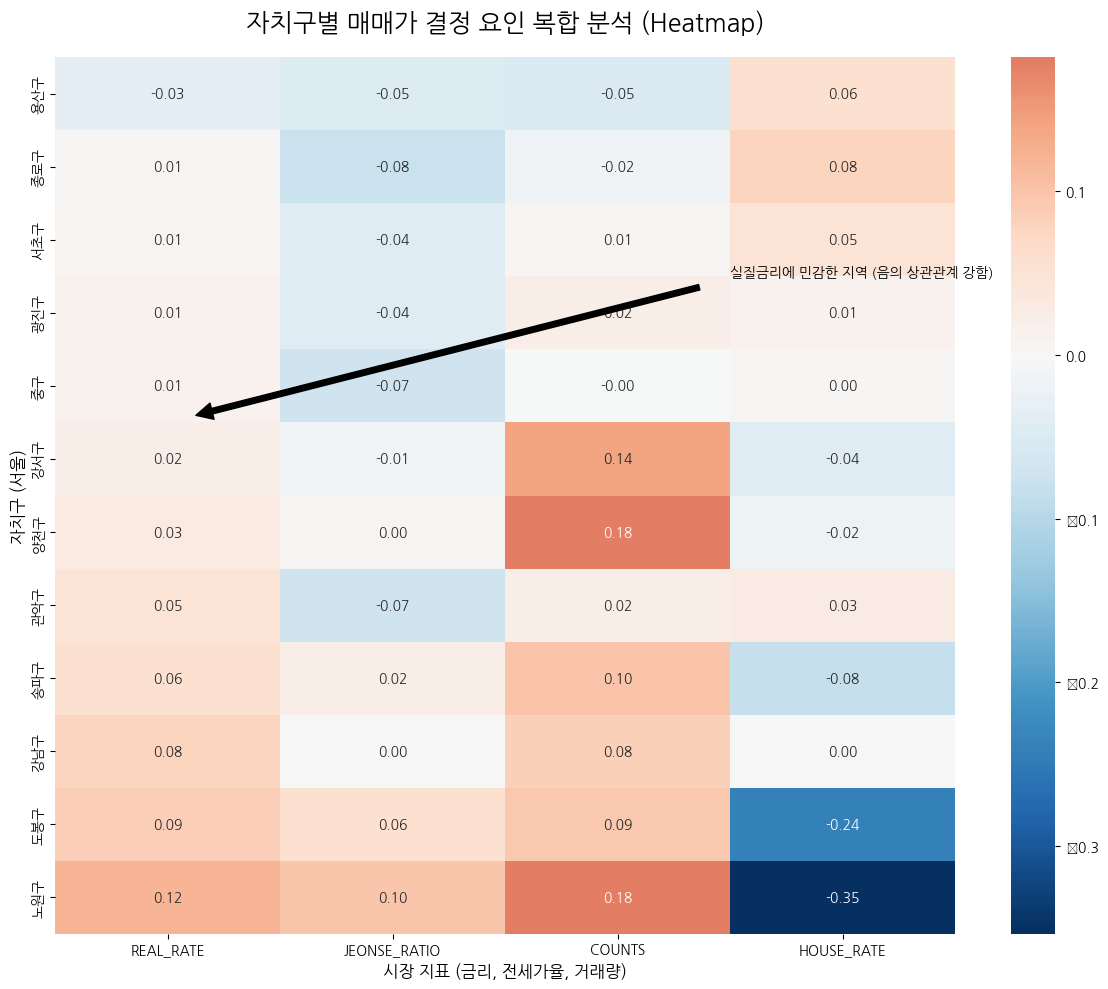

/home/hyuksu/projects/ml/.venv/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()
/home/hyuksu/projects/ml/.venv/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  self._figure.tight_layout(*args, **kwargs)
/home/hyuksu/projects/ml/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


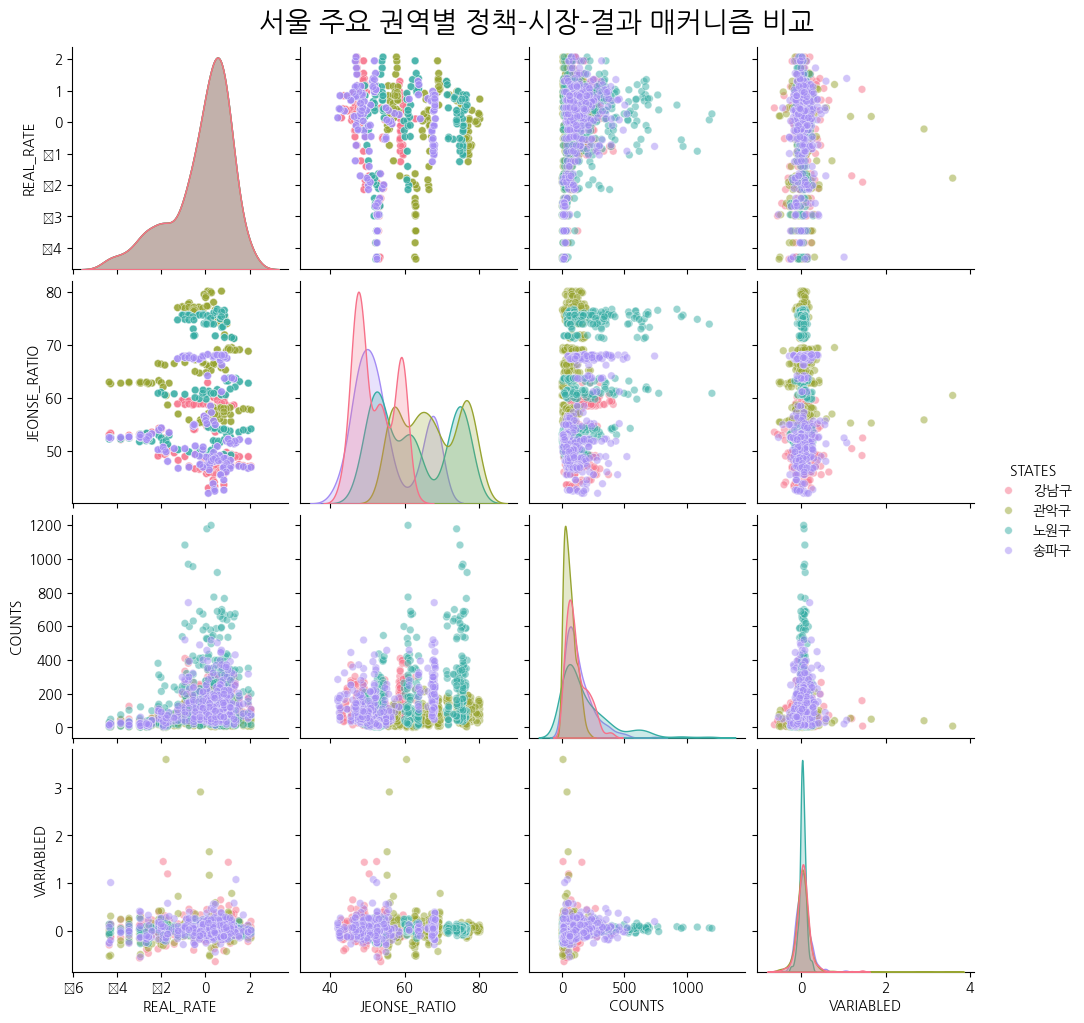

In [82]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 자치구별 '매매가 변화율(VARIABLED)'과 타 지표들 간의 상관관계 계산
# 이를 통해 각 구의 '성격'을 정의합니다.
corr_data = []
for state in df['STATES'].unique():
    subset = df[df['STATES'] == state]
    corrs = subset[['VARIABLED', 'REAL_RATE', 'JEONSE_RATIO', 'COUNTS', 'HOUSE_RATE']].corr()['VARIABLED']
    corrs['STATES'] = state
    corr_data.append(corrs)

df_corr_summary = pd.DataFrame(corr_data).set_index('STATES').drop(columns='VARIABLED')

# 2. 히트맵 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(df_corr_summary.sort_values('REAL_RATE'), annot=True, cmap='RdBu_r', center=0, fmt='.2f')

plt.title('자치구별 매매가 결정 요인 복합 분석 (Heatmap)', fontsize=18, pad=20)
plt.xlabel('시장 지표 (금리, 전세가율, 거래량)', fontsize=12)
plt.ylabel('자치구 (서울)', fontsize=12)

# 가설을 설명하는 주석 추가
plt.annotate('실질금리에 민감한 지역 (음의 상관관계 강함)', xy=(0.5, 5), xytext=(3, 3),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.tight_layout()
plt.show()

# 분석을 위해 주요 자치구 샘플링 (강남, 관악, 송파 포함)
target_list = ['강남구', '관악구', '송파구', '노원구']
df_sample = df[df['STATES'].isin(target_list)]

# 시각화: 지표 간의 관계를 구별 색상으로 분리
g = sns.pairplot(df_sample, 
                 vars=['REAL_RATE', 'JEONSE_RATIO', 'COUNTS', 'VARIABLED'],
                 hue='STATES', 
                 palette='husl',
                 diag_kind='kde', 
                 plot_kws={'alpha': 0.5, 's': 30})

g.fig.suptitle('서울 주요 권역별 정책-시장-결과 매커니즘 비교', fontsize=20, y=1.02)
plt.show()

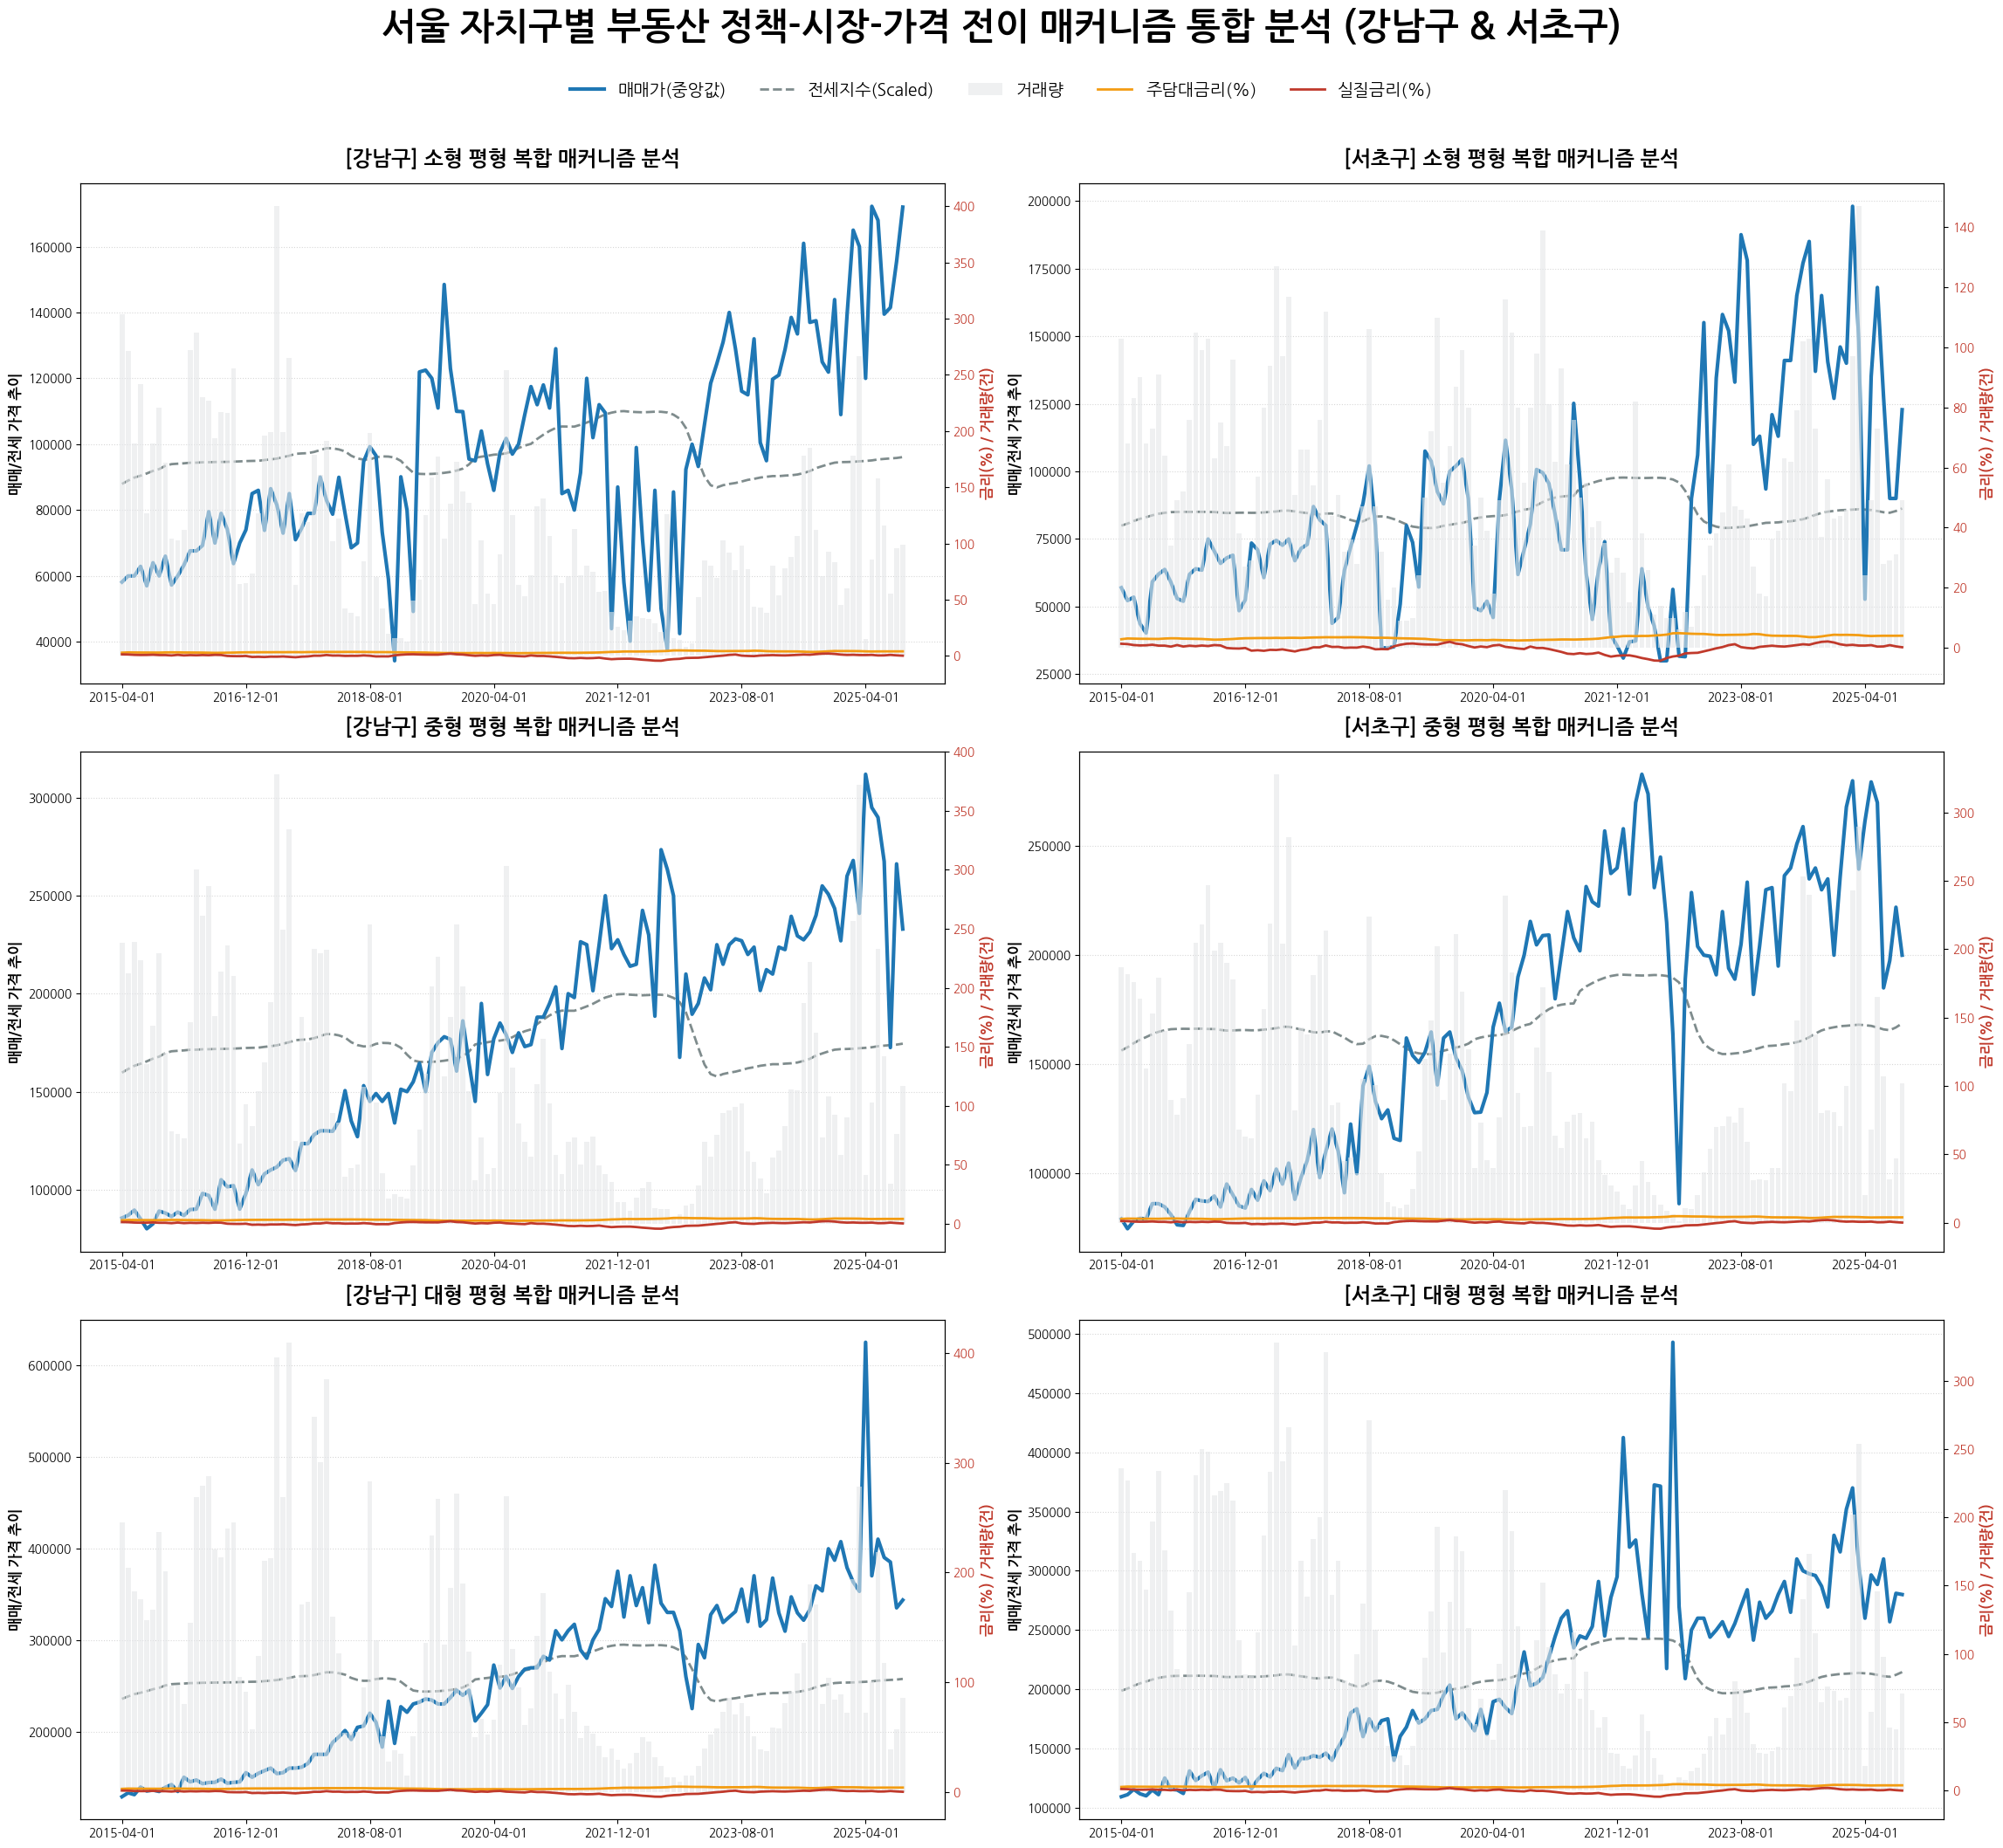

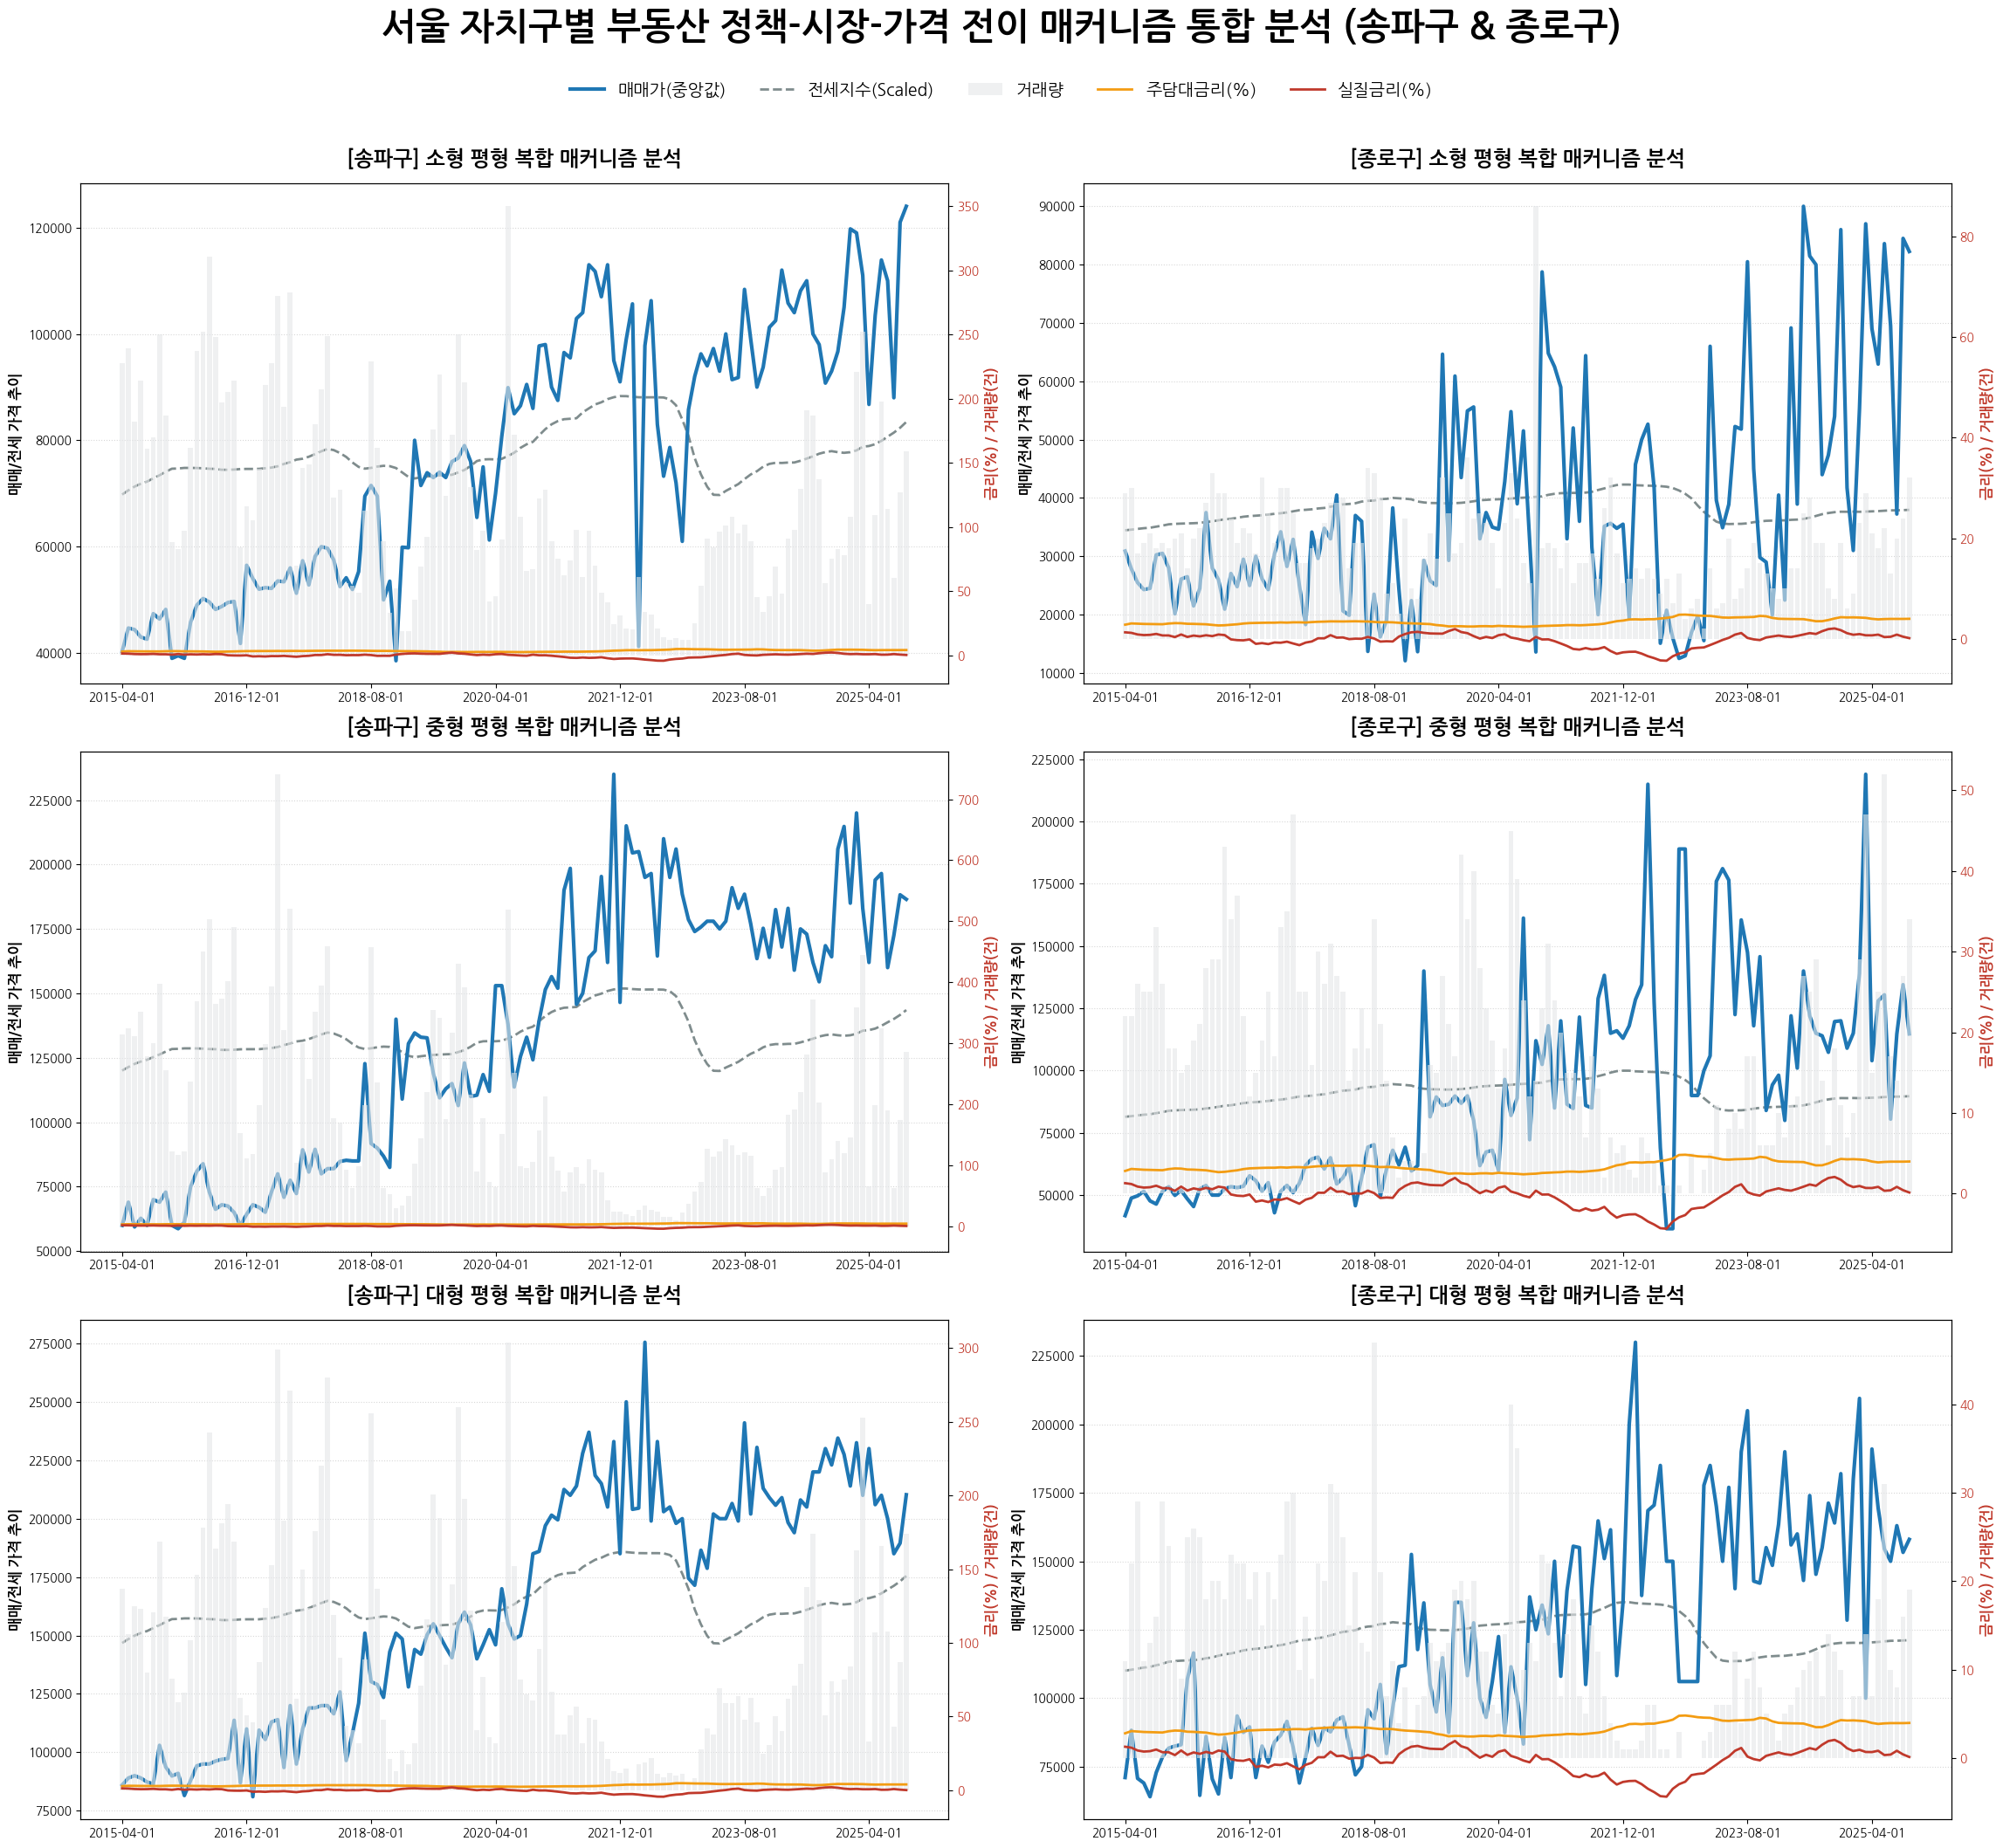

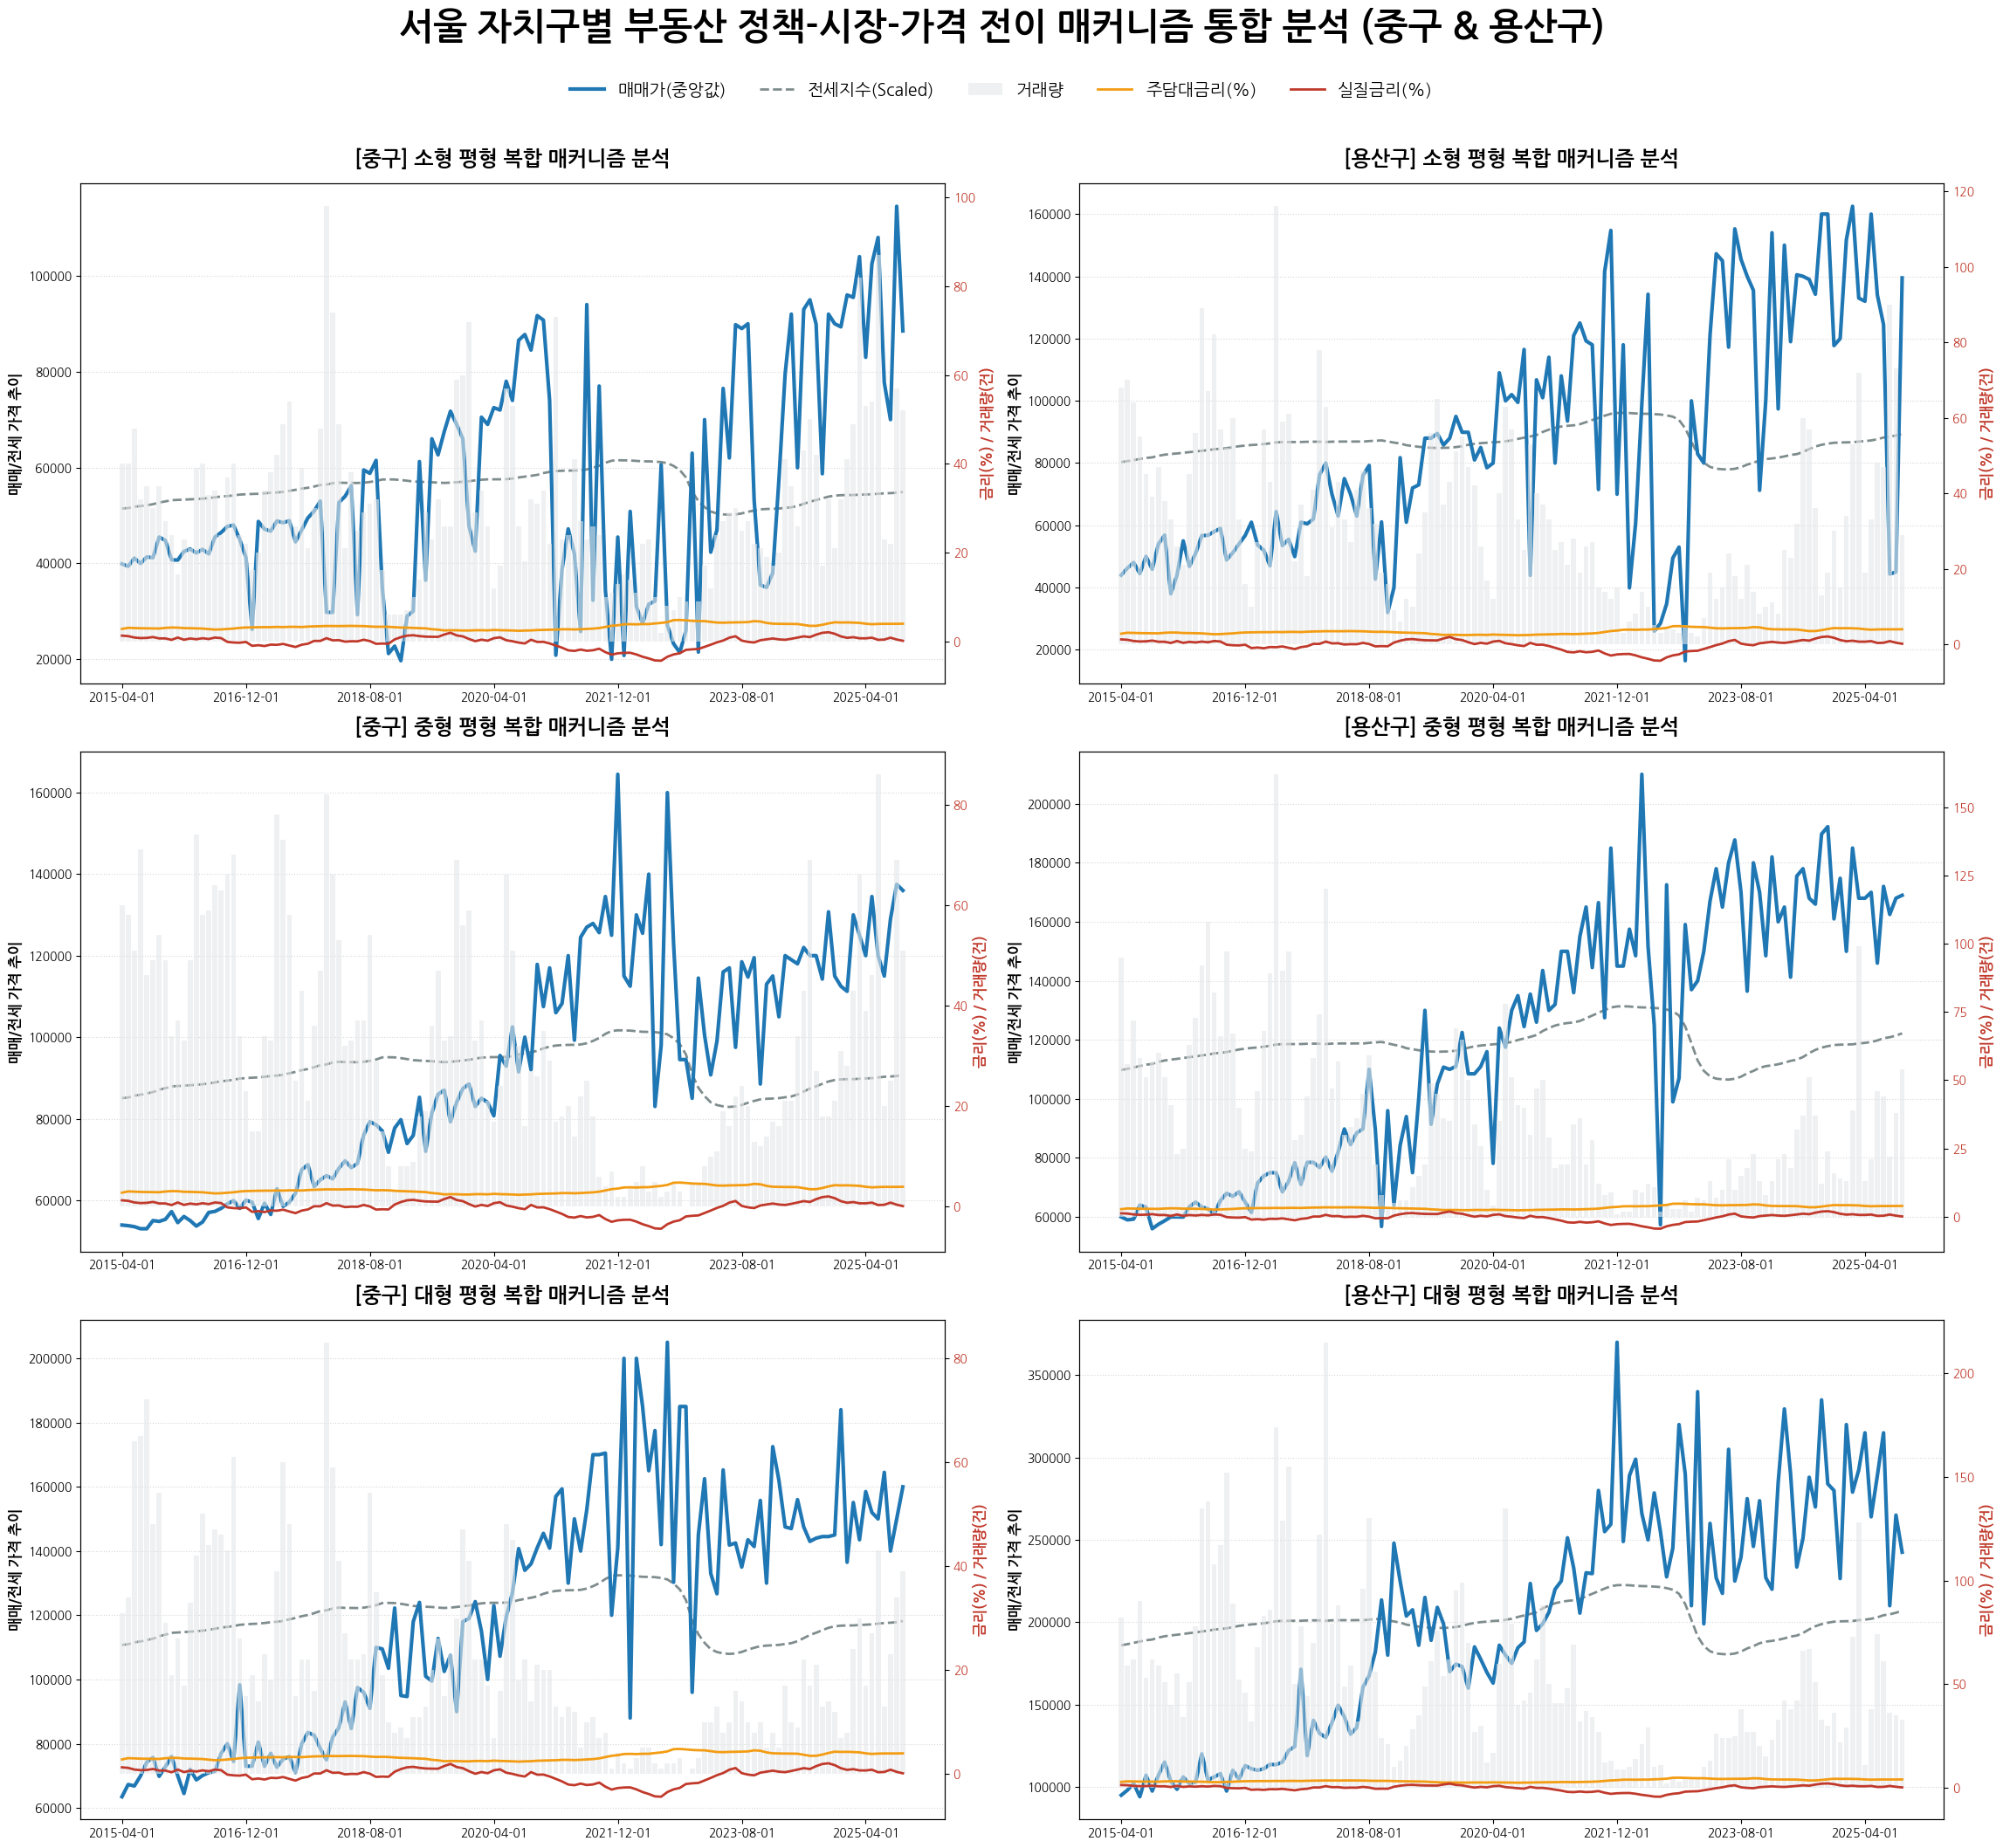

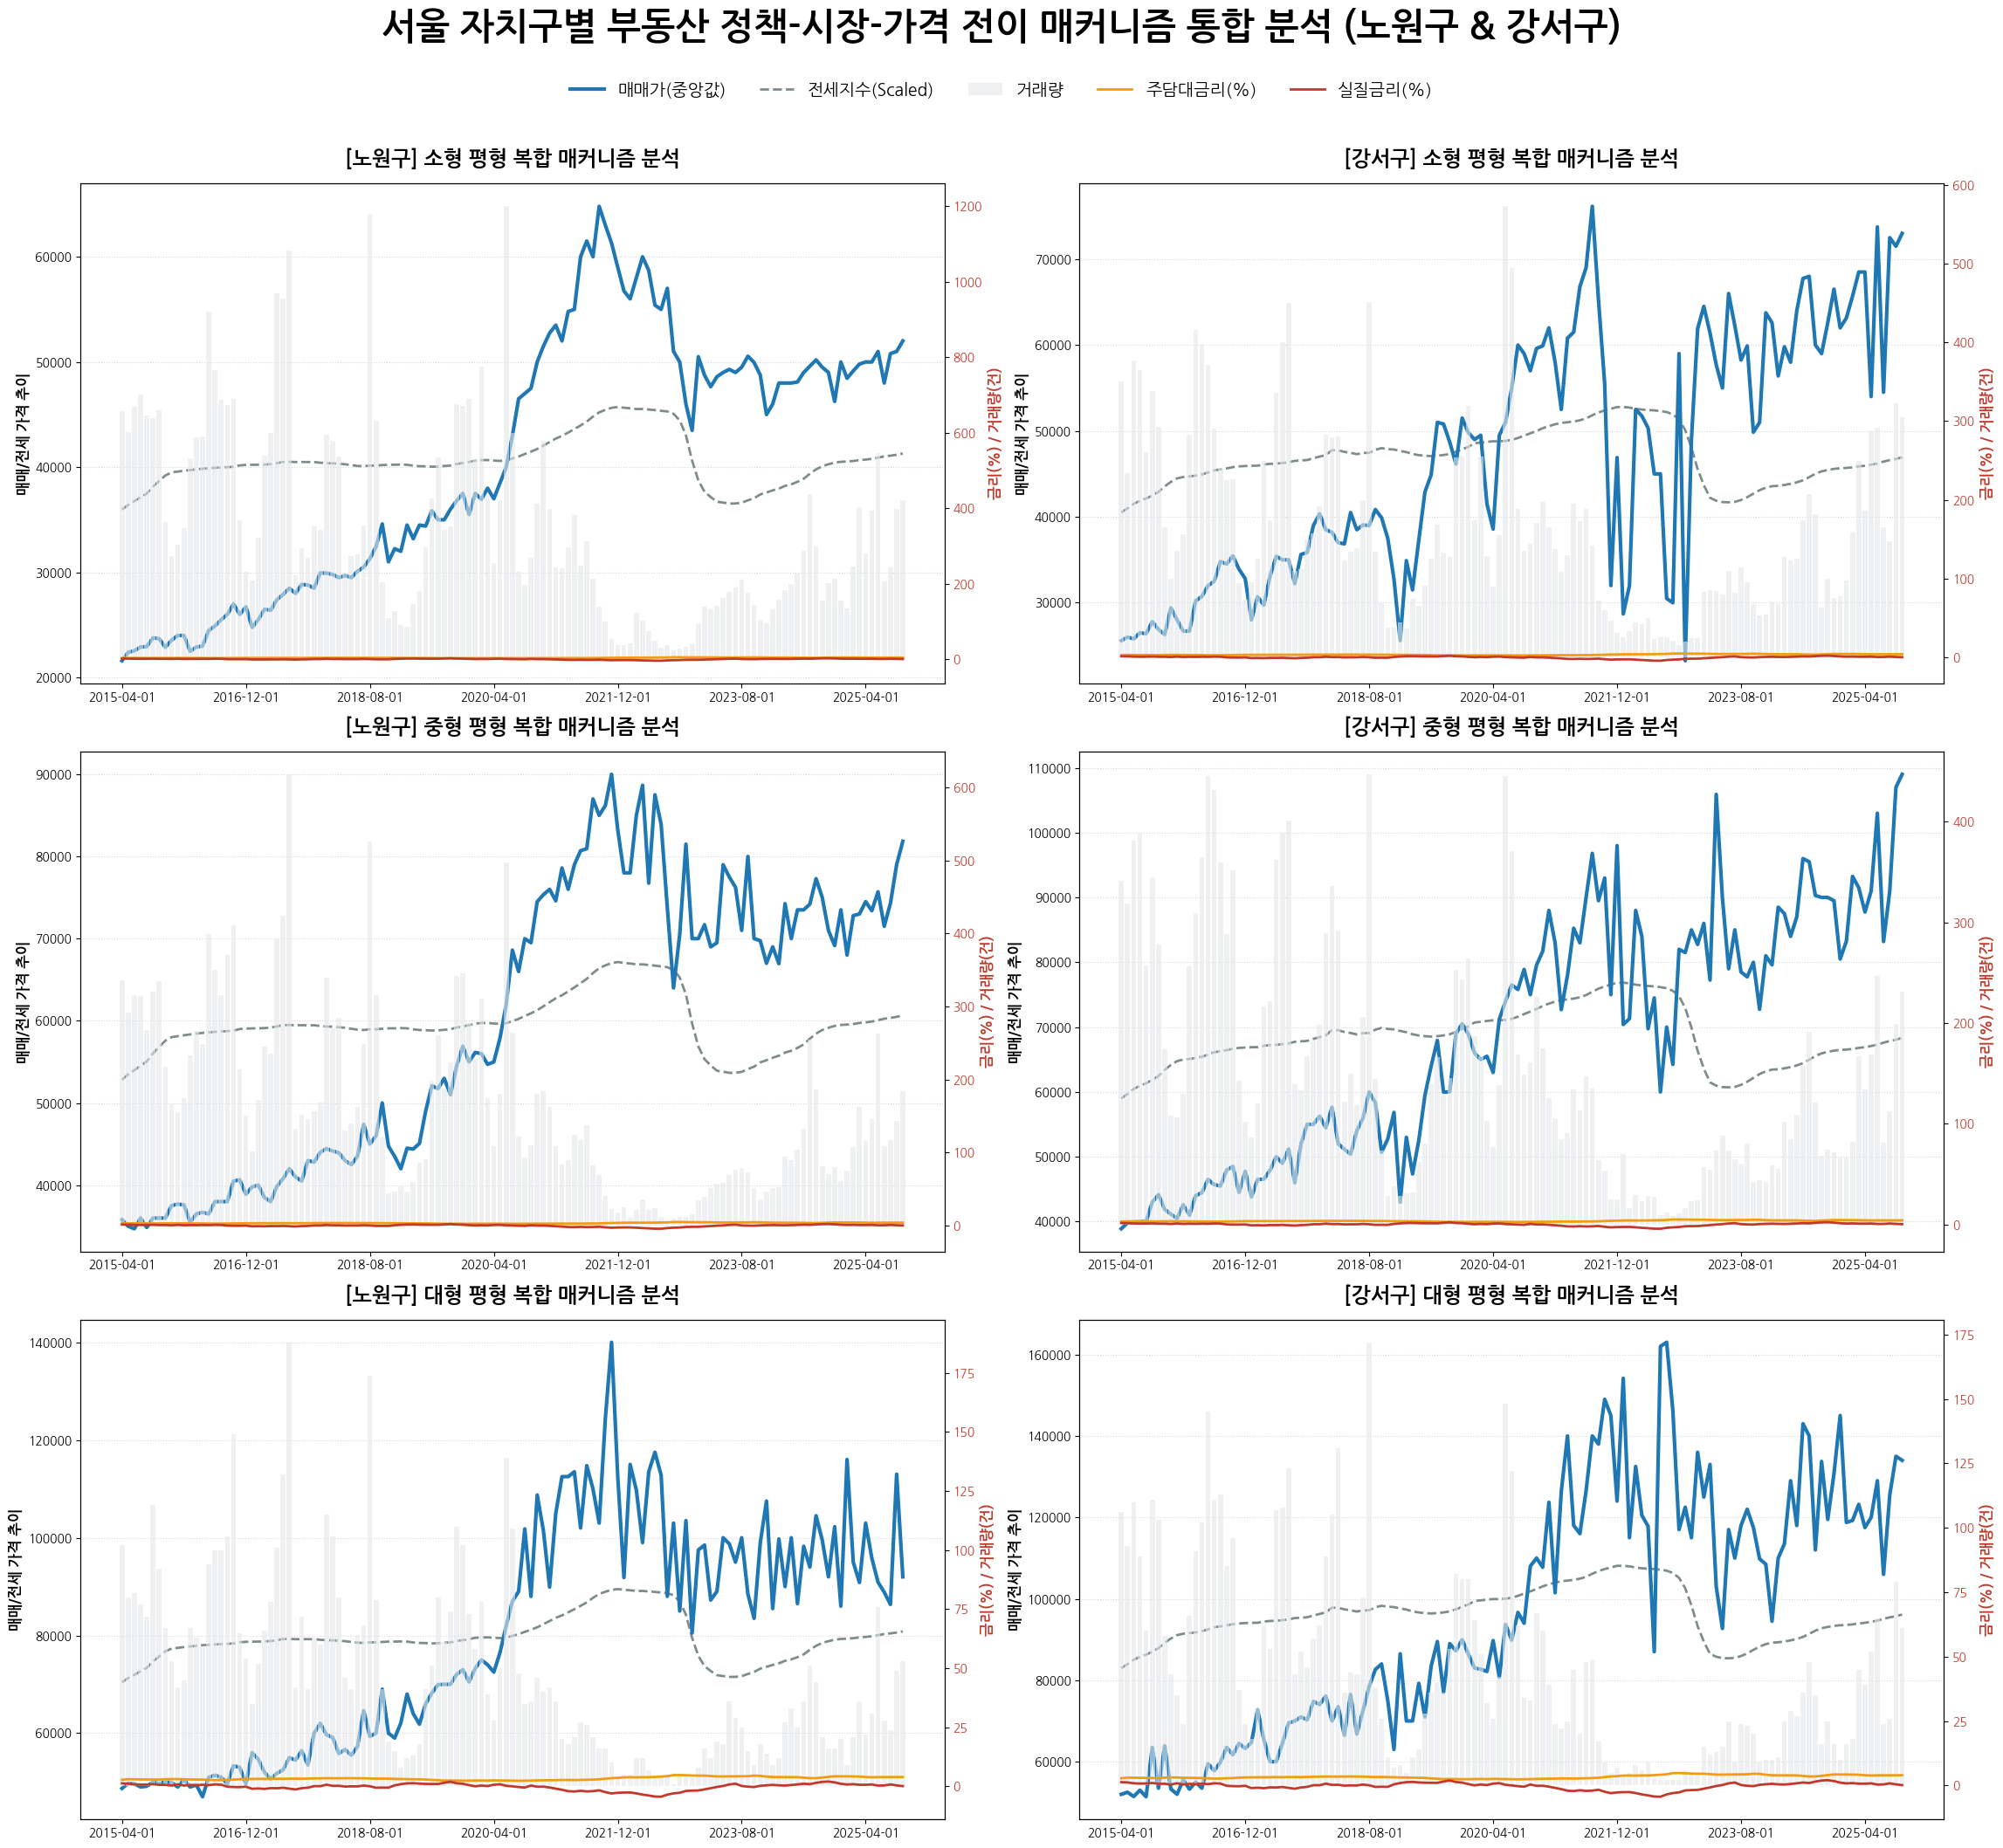

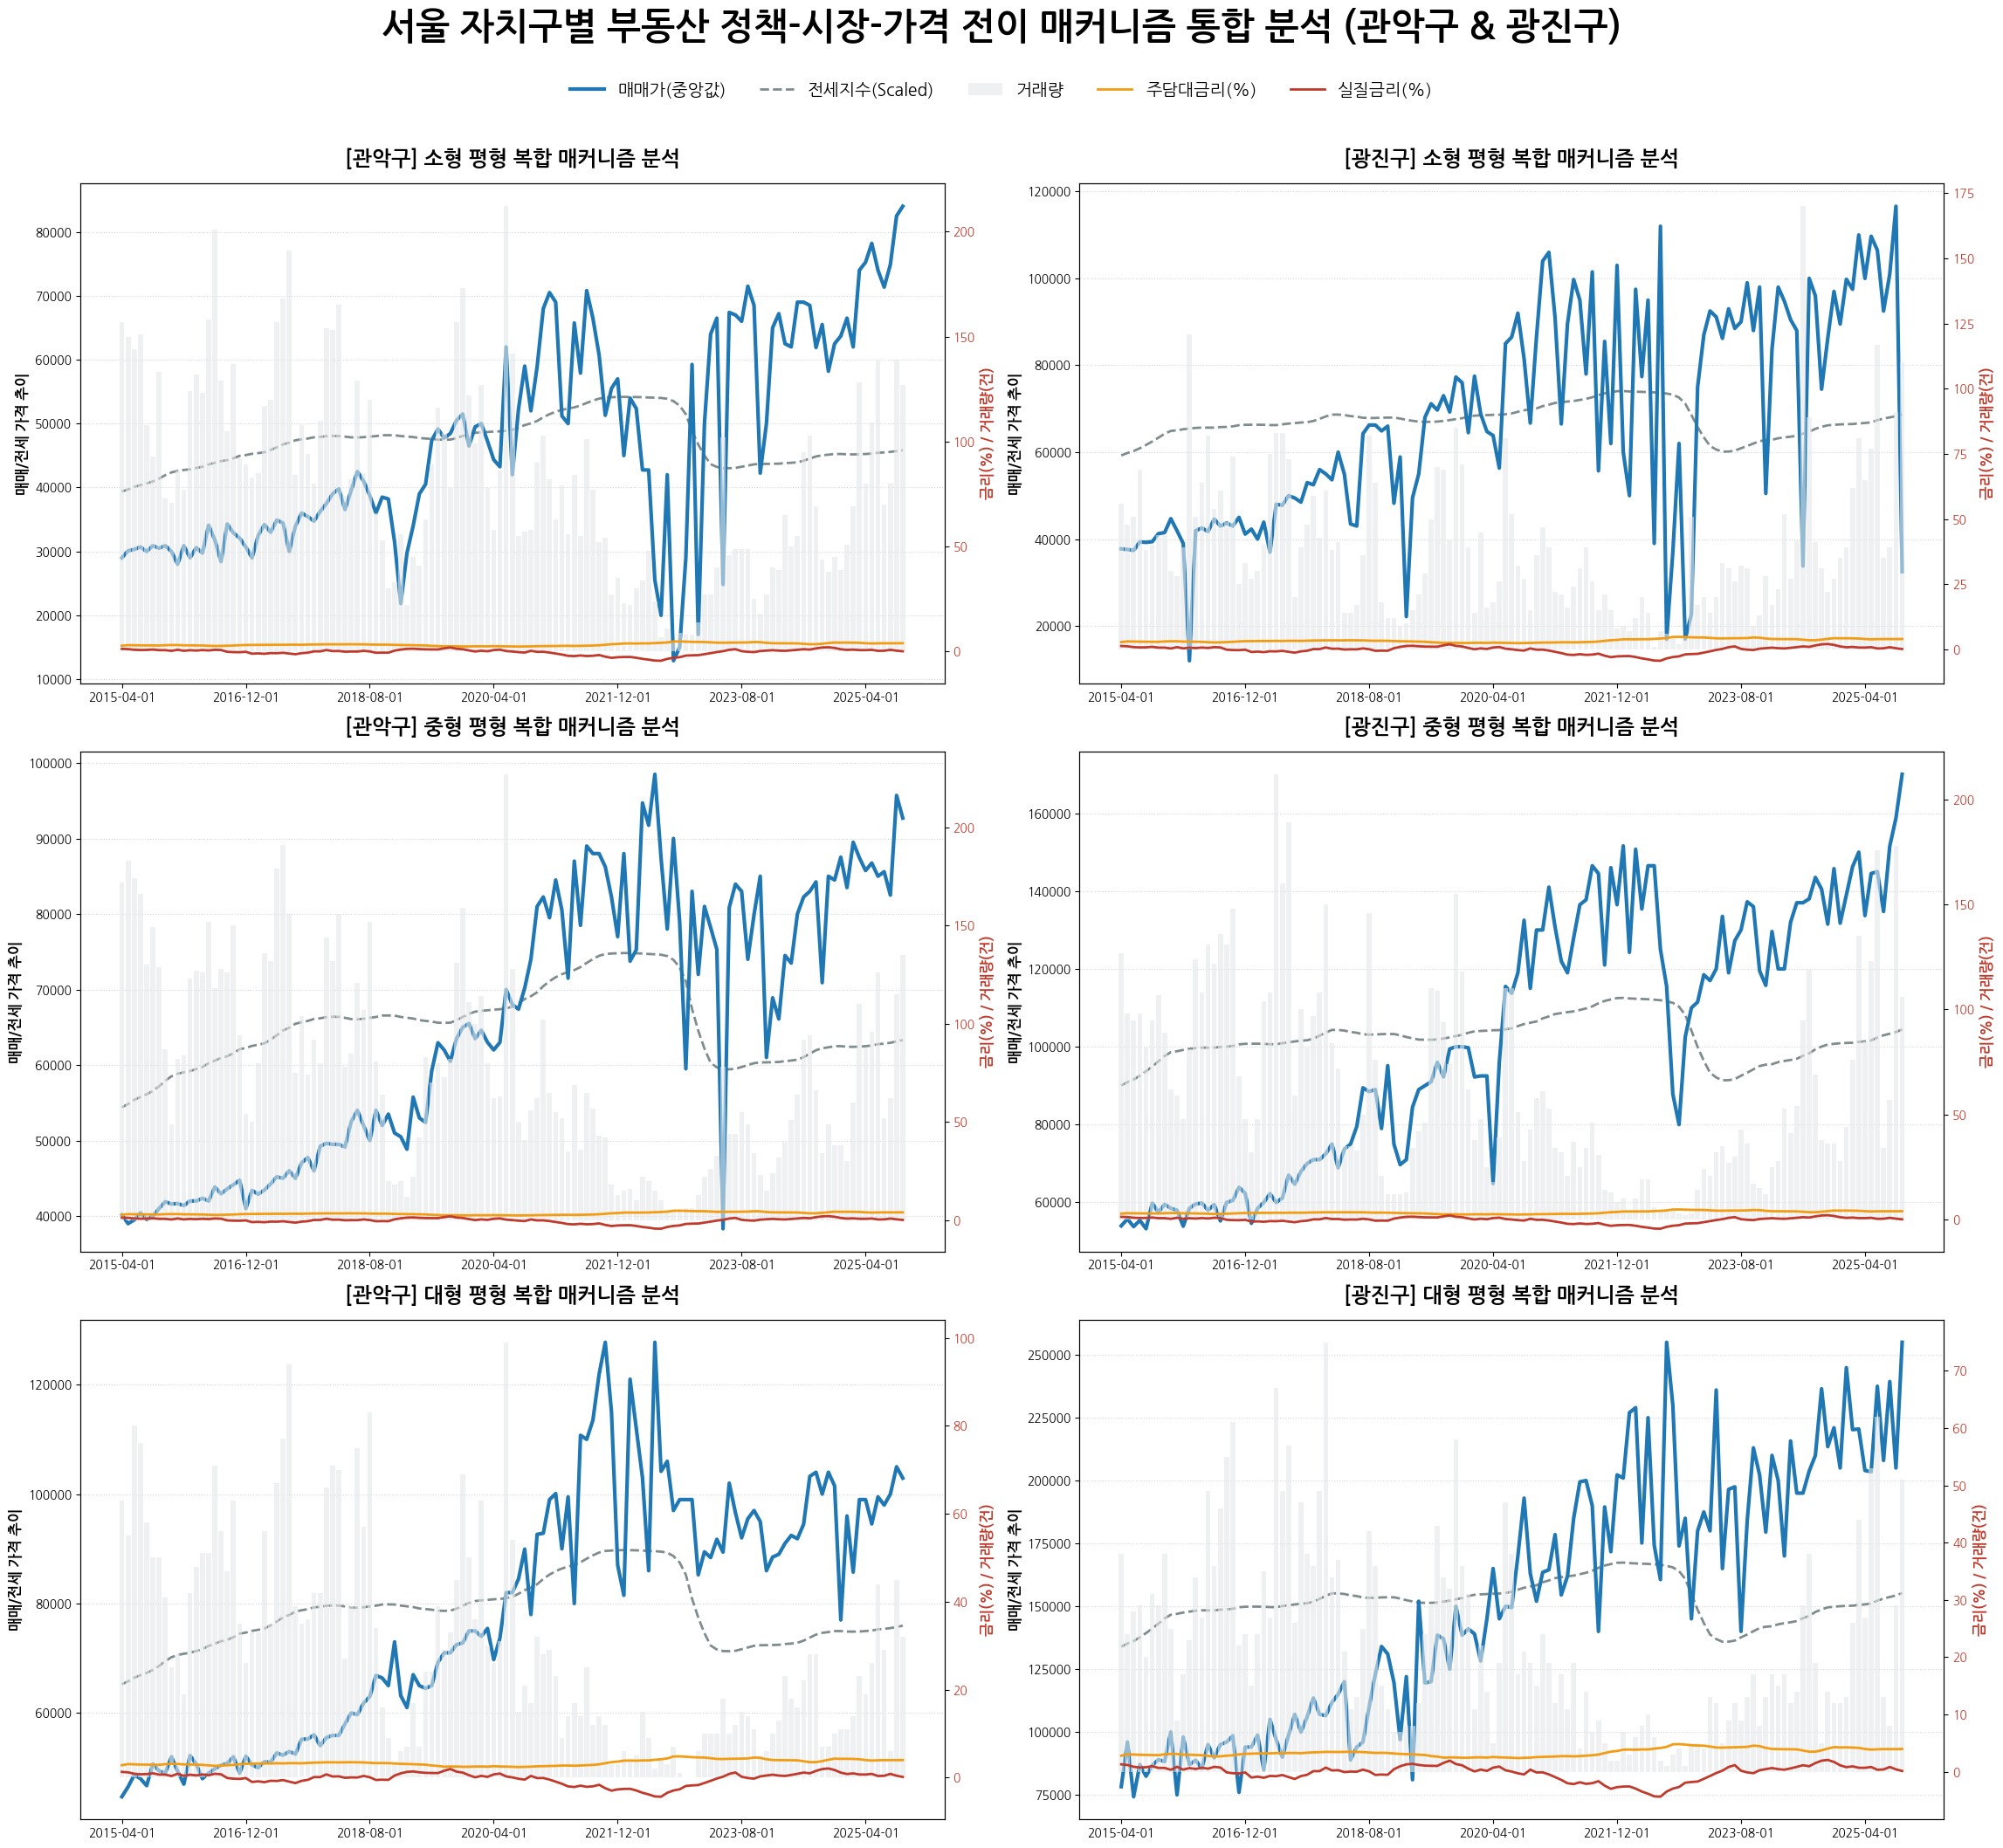

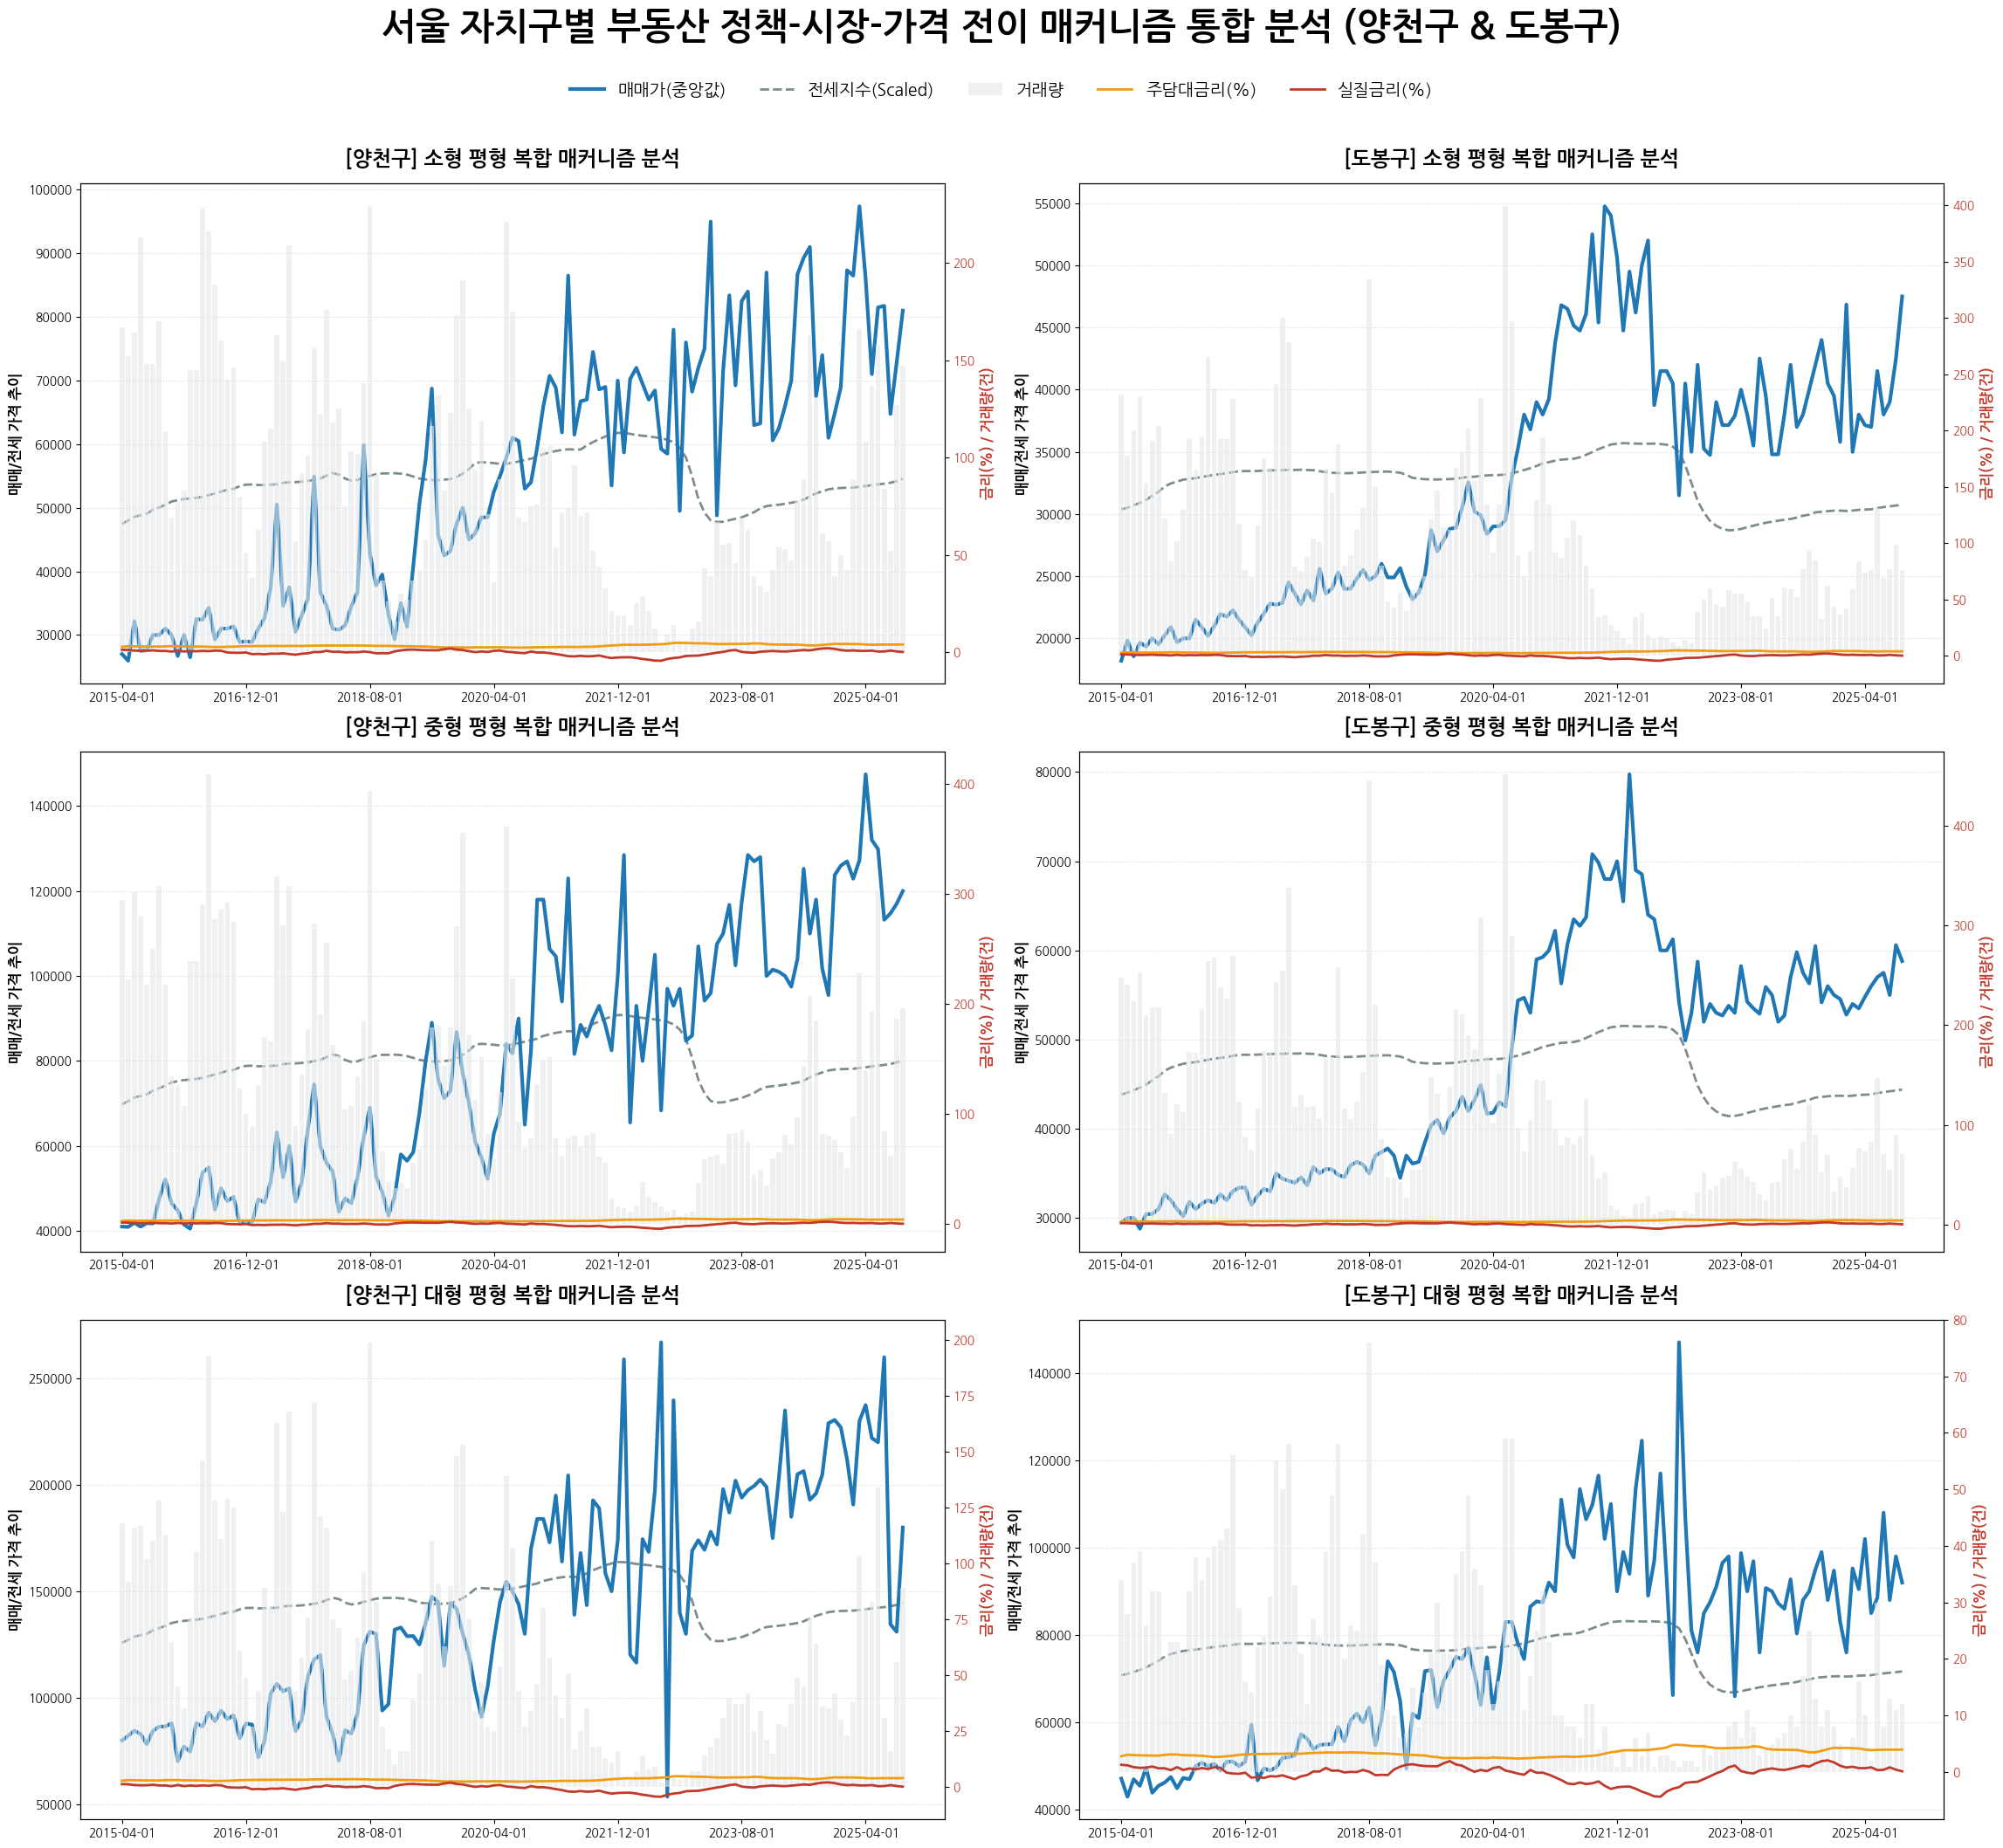

In [83]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# 자치구 쌍 리스트
state_pairs = [
    ('강남구', '서초구'), ('송파구', '종로구'), ('중구', '용산구'),
    ('노원구', '강서구'), ('관악구', '광진구'), ('양천구', '도봉구')
]
sizes = ['소형', '중형', '대형']

def plot_final_dashboard(state_pair):
    # 3행 2열 구조, 가로를 넓게 설정하여 시원하게 배치
    fig, axes = plt.subplots(3, 2, figsize=(24, 22))
    plt.subplots_adjust(hspace=0.45, wspace=0.35)
    
    for col, state_name in enumerate(state_pair):
        for row, size in enumerate(sizes):
            ax1 = axes[row, col]
            
            # 데이터 필터링
            data = df[(df['STATES'] == state_name) & (df['SIZE'] == size)].copy()
            data = data.sort_values('DATE_YM')
            if data.empty: continue

            x_dates = data['DATE_YM'].astype(str)
            
            # --- 1. 가격 지표 (왼쪽 Y축) ---
            # 매매가는 파란색 두꺼운 실선
            ln1 = ax1.plot(x_dates, data['PRICE_MEDIAN'], color='#1F77B4', linewidth=3, label='매매가(중앙값)', zorder=5)
            # 전세가는 회색 점선 (매매가와 비교를 위해 스케일 유지)
            # 전세가율이 높을수록 전세선이 매매가선에 바짝 붙습니다.
            scaled_jeonse = data['JEONSE_PRICE'] * (data['PRICE_MEDIAN'].mean() / data['JEONSE_PRICE'].mean())
            ln2 = ax1.plot(x_dates, scaled_jeonse, color='#7F8C8D', linestyle='--', linewidth=2, label='전세지수(Scaled)', zorder=4)
            ax1.set_ylabel('매매/전세 가격 추이', fontsize=12, fontweight='bold')
            
            # --- 2. 환경 지표 (오른쪽 Y축) ---
            ax2 = ax1.twinx()
            # 거래량은 배경에 연한 막대로 (zorder=1)
            bar = ax2.bar(x_dates, data['COUNTS'], color='#E5E7E9', alpha=0.6, label='거래량', zorder=1)
            # 주담대 금리는 오렌지색, 실질 금리는 빨간색으로 대비
            ln3 = ax2.plot(x_dates, data['HOUSE_RATE'], color='#F39C12', linewidth=2, label='주담대금리(%)', zorder=3)
            ln4 = ax2.plot(x_dates, data['REAL_RATE'], color='#C0392B', linewidth=2, label='실질금리(%)', zorder=3)
            ax2.set_ylabel('금리(%) / 거래량(건)', color='#C0392B', fontsize=12, fontweight='bold')
            ax2.tick_params(axis='y', labelcolor='#C0392B')

            # 차트 제목 및 격자
            ax1.set_title(f'[{state_name}] {size} 평형 복합 매커니즘 분석', fontsize=17, fontweight='bold', pad=15)
            ax1.xaxis.set_major_locator(ticker.MaxNLocator(7))
            ax1.grid(True, axis='y', linestyle=':', alpha=0.5)
            
            # --- 범례 통합 (상단에 한 줄로 깔끔하게) ---
            if row == 0 and col == 0:
                lines = ln1 + ln2 + [bar] + ln3 + ln4
                labels = [l.get_label() for l in lines]
                fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 0.96),
                           ncol=5, fontsize=14, frameon=False)

    plt.suptitle(f'서울 자치구별 부동산 정책-시장-가격 전이 매커니즘 통합 분석 ({state_pair[0]} & {state_pair[1]})', 
                 fontsize=30, fontweight='bold', y=0.99)
    
    plt.tight_layout(rect=[0.02, 0.03, 0.98, 0.95])
    plt.show()

# 실행
for pair in state_pairs:
    plot_final_dashboard(pair)